# 0.0 IMPORTS

In [1]:
import math
import inflection
import datetime
import pickle

import numpy    as np
import pandas   as pd
import seaborn  as sns

from scipy                     import stats  as ss
from matplotlib                import pyplot as plt
from IPython.core.display      import HTML
from IPython.display           import Image
from tabulate                  import tabulate
from sklearn.preprocessing     import MinMaxScaler, RobustScaler, LabelEncoder
from boruta                    import BorutaPy
from sklearn.ensemble          import RandomForestRegressor
from sklearn.linear_model      import LinearRegression, Lasso
from xgboost                   import XGBRegressor
from sklearn.metrics           import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## 0.1 Helper Functions

In [2]:
def personal_settings(): 
    
    # notbook
    display(HTML('<style>.container{width:98% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.options.display.float_format = '{:.2f}'.format
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(22,10)})
    sns.set_theme(style = 'darkgrid', font_scale = 1.2)
    #sns.set_palette('viridis_r')
    
    return None

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min( kcorr-1, rcorr-1 )))


# ml_error function (7 Machine Learning Modeling)
def ml_error(model_name, y, yhat): # y: real values, yhat: predicted values
    mae  = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rsme = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rsme}, index=[0])

# cross_validation (7 Machine Learning Modeling)
def cross_validation(X_training, kfold, model_name, model, verbose=False):

    mae_list=[]
    mape_list=[]
    rmse_list=[]

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\n Kfold number: {}'.format(k))

        # start and end validation dates
        validation_start = X_training['date'].max() - datetime.timedelta(days=k*6*7) # six weeks times seven days
        validation_end   = X_training['date'].max() - datetime.timedelta(days=(k-1)*6*7) # six weeks times seven days

        # filtering dataset
        training   = X_training[X_training['date']  < validation_start] 
        validation = X_training[(X_training['date'] >= validation_start) & (X_training['date'] <= validation_end)]

        # training and validation dataset
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # performance storage
        mae_list.append(m_result['MAE']) 
        mape_list.append(m_result['MAPE']) 
        rmse_list.append(m_result['RMSE']) 


    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV' : np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y )

In [3]:
personal_settings()

## 0.2 Load  Data

In [4]:
df_sales_raw = pd.read_csv('data/raw/train.csv', low_memory=False )
df_store_raw = pd.read_csv('data/raw/store.csv', low_memory=False )

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


## 1.1 Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
new_cols  = list(map(snakecase, old_cols))

# rename
df1.columns = new_cols

df1.rename(columns={'promo': 'is_promo', 'promo2': 'promo2_participant', 'promo_interval':'promo2_interval'},  inplace = True)
df1.columns 

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open',
       'is_promo', 'state_holiday', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2_participant',
       'promo2_since_week', 'promo2_since_year', 'promo2_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print(df1.shape[0], 'rows')
print(df1.shape[1], 'columns')

1017209 rows
18 columns


## 1.3 Data Types

In [9]:
description = []

for i in df1.columns:
    description.append([
        i,
        df1[i].dtypes,
        df1[i].nunique(),
        df1[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data=description, columns=['attributes', 'dtypes', 'nunique', 'sample'])

,attributes,dtypes,nunique,sample
0,store,int64,1115,"[776, 469]"
1,day_of_week,int64,7,"[4, 1]"
2,date,object,942,"[2015-02-03, 2015-05-18]"
3,sales,int64,21734,"[4450, 11738]"
4,customers,int64,4086,"[126, 2406]"
5,open,int64,2,"[0, 1]"
6,is_promo,int64,2,"[1, 0]"
7,state_holiday,object,4,"[c, b]"
8,school_holiday,int64,2,"[0, 1]"
9,store_type,object,4,"[b, c]"


## 1.4 Check NA

In [10]:
description = []
for i in df1.columns:
    description.append([
        i,
        df1[i].isna().sum(),
        round((df1[i].isna().sum()/len(df1))*100)
    ])

pd.DataFrame(data=description, columns=['attributes','null', '%null'])

,attributes,null,%null
0,store,0,0
1,day_of_week,0,0
2,date,0,0
3,sales,0,0
4,customers,0,0
5,open,0,0
6,is_promo,0,0
7,state_holiday,0,0
8,school_holiday,0,0
9,store_type,0,0


## 1.5 Fillout NA

To fill in the missing values, we will make some business assumptions. 

For 'competition_distance' we will assume that the closest competitor is so far away that there is no competitor, so to fill in this missing data, we will use a value much higher than the maximum value in 'competition_distance'.

In [11]:
# 'competition_distance'
max_dist = df1['competition_distance'].max()
new_max_dist = max_dist * 1.5

print('Max distance:', max_dist)
print('New Max distance:', new_max_dist)

# fill NAs
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: new_max_dist if math.isnan(x) else x)

Max distance: 75860.0
New Max distance: 113790.0


For 'competition_open_since_month' and 'competition_open_since_year', let's assume two reasons why those columns are empty, the store has no nearest competitor, or the store has a nearby competitor but we don't know when it opened (either because it opened much earlier than the store, or because it opened later and someone forgot to write it down).

If the 'competition_open_since_month' is NA we will copy the sale date of that line to 'competition_open_since_month'. With this reasoning, we are thinking one step ahead (feature engineering). There are some variables that we derive from time that are very important, to represent the behavior. One of them is "how long has it been since an event happened".

In this sale, how long has it been since I had an open competition? 
If you have a store and it has no close competitor, you have a certain amount of sales, when a close competition opens up, those sales tend to drop, because the customers split up. When that competition gets more mature, sales grow again, but they don't stay at the same level as before you had a competitor. We don't know if it will work, but we will test it in the first CRISP cycle.

The same reasoning applies to 'competition_open_since_year'.

In [12]:
df1['date'] = pd.to_datetime(df1['date'])

# 'competition_open_since_month' and 'competition_open_since_year'
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else 
                                                          x['competition_open_since_month'], axis=1)

df1['competition_open_since_year']  = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else 
                                                          x['competition_open_since_year'] , axis=1)

For 'promo2_since_week' and 'promo2_since_year', to fillout the missing values, we will use the same reasoning used in 'competition_open_since_month' and 'competition_open_since_year'.

In [13]:
# promo2_since_week and 'promo2_since_year'
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else 
                                               x['promo2_since_week'], axis=1).astype('int64')

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else 
                                               x['promo2_since_year'], axis=1).astype('int64')

In [14]:
# 'promo_interval' 
# creating a dictionary to replace the number of the month (which I will extract from date) with the name
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

# replacing every NA in 'promo_inteval' with 0, because these are stores that did not participate in the promotion
df1['promo2_interval'].fillna(0, inplace=True)

# extracting the month from date with 'month_map'
df1['month_map'] = df1['date'].dt.month.map(month_map)

# variable to tell if the purchase happened on a promotion
df1['is_promo2'] = df1[['promo2_interval', 'month_map']].apply(lambda x: 0 if x['promo2_interval'] == 0 else 
                                                                         1 if x['month_map'] in x['promo2_interval'].split(',') else 0, axis=1)

In [15]:
df1[['date', 'promo2_interval', 'month_map', 'is_promo2']].sample(5).T

,133862,1016367,145933,882331,854409
date,2015-04-02 00:00:00,2013-01-01 00:00:00,2015-03-23 00:00:00,2013-05-01 00:00:00,2013-05-27 00:00:00
promo2_interval,"Feb,May,Aug,Nov",0,"Jan,Apr,Jul,Oct",0,"Feb,May,Aug,Nov"
month_map,Apr,Jan,Mar,May,May
is_promo2,0,0,0,0,1


In [16]:
description = []
for i in df1.columns:
    description.append([
        i,
        df1[i].isna().sum(),
        round((df1[i].isna().sum()/len(df1))*100)
    ])

pd.DataFrame(data=description, columns=['attributes','null', '%null'])

,attributes,null,%null
0,store,0,0
1,day_of_week,0,0
2,date,0,0
3,sales,0,0
4,customers,0,0
5,open,0,0
6,is_promo,0,0
7,state_holiday,0,0
8,school_holiday,0,0
9,store_type,0,0


## 1.6 Change Data Types

In [17]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype(np.int64)

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

## 1.7. Descriptive Statistics

In [18]:
df_num1 = df1.select_dtypes(include = ['int64', 'float64'])
df_cat1 = df1.select_dtypes(exclude = ['int64', 'float64'])

### 1.7.1 Numerical Attributes

In [19]:
# central tendency - mean, median
ct1 = pd.DataFrame(df_num1.apply(np.mean)).T
ct2 = pd.DataFrame(df_num1.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df_num1.apply(np.std)).T 
d2 = pd.DataFrame(df_num1.apply(min)).T
d3 = pd.DataFrame(df_num1.apply(max)).T
d4 = pd.DataFrame(df_num1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df_num1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df_num1.apply(lambda x: x.kurtosis())).T

# concat
num1_summary = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num1_summary.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
num1_summary

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,is_promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,113790.00,113770.00,5711.53,2330.00,9475.73,5.37,47.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


In [20]:
df_num1.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes'})

,attributes,min,max,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,5773.82,5744.00,3849.93,0.64,1.78
3,customers,0.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,is_promo,0.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,113790.00,5711.53,2330.00,9475.74,5.37,47.79
8,competition_open_since_month,1.00,12.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,2010.32,2012.00,5.52,-7.24,124.07


### 1.7.2 Categorical Attributes

In [21]:
cat1_summary = df_cat1.astype('category').describe().T.drop(columns = 'count')
cat1_summary

,unique,top,freq
date,942,2014-04-17 00:00:00,1115
state_holiday,4,0,986159
store_type,4,a,551627
assortment,3,a,537445
promo2_interval,4,0,508031
month_map,12,Mar,103695


In [22]:
print('Date min:', df_cat1['date'].min())
print('Date max:', df_cat1['date'].max())

Date min: 2013-01-01 00:00:00
Date max: 2015-07-31 00:00:00


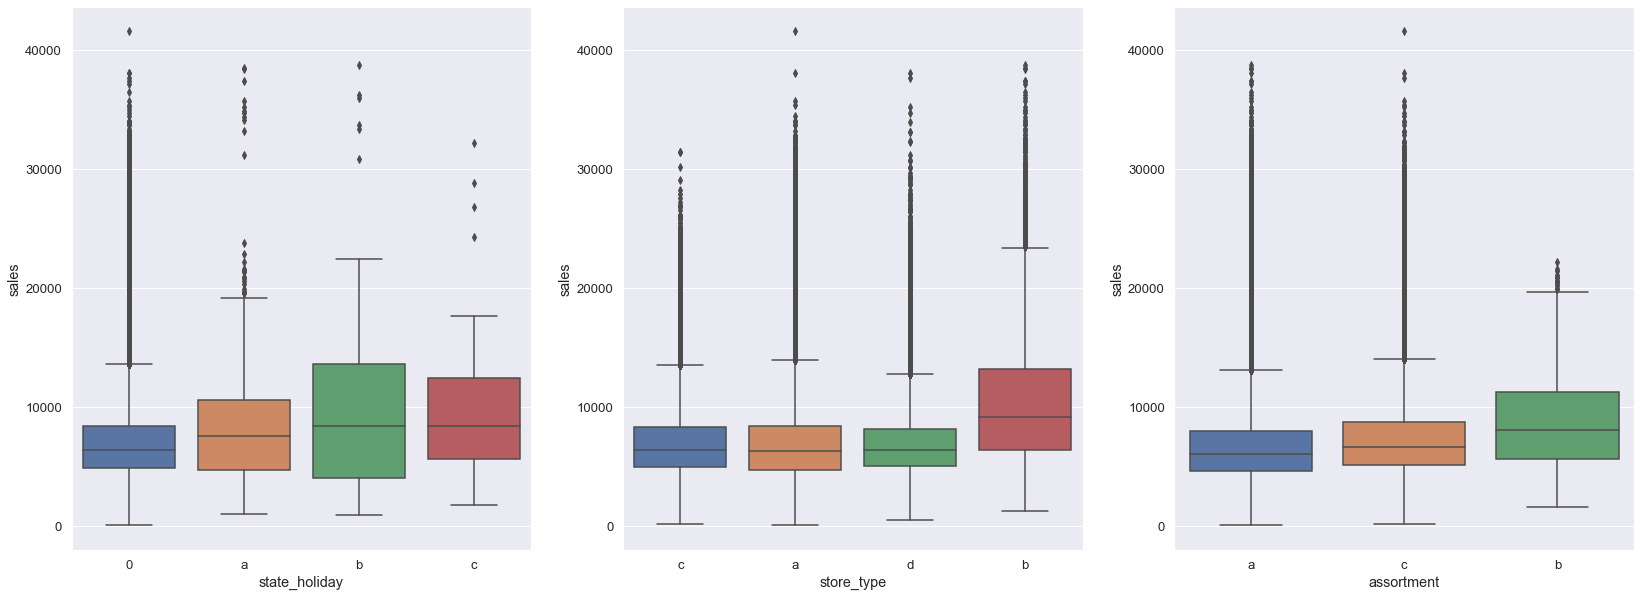

In [23]:
# how the sales are distributed within each of the state_holiday, store_type and assortment variables.
aux = df1[df1['sales'] > 0]

plt.figure(figsize=(28, 10))

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux)

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux)

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux);

# 2.0  FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

## 2.1 Hypotesis Mind Map

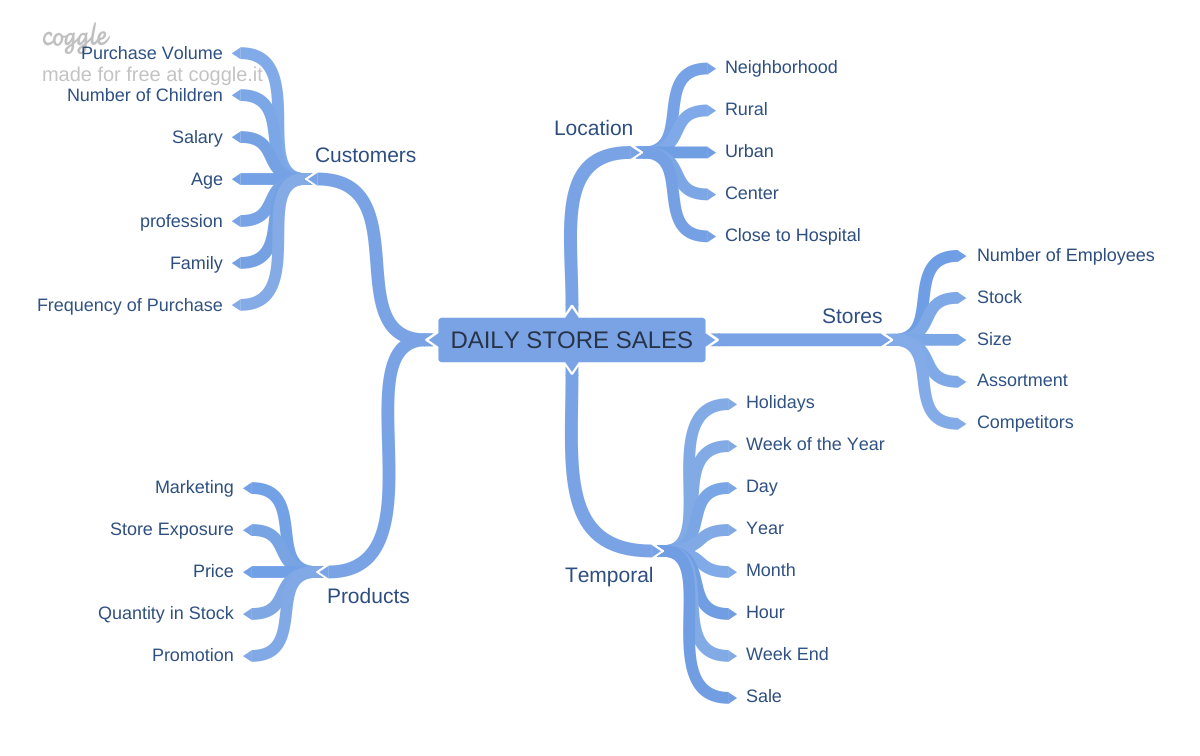

In [25]:
Image('images/mind_map.png')

## 2.2 Hypothesis List

**1.** On on average, stores with a wider assortment should sell more.  

**2.** On avarange, stores with closer competitors should sell less.   

**3.** Stores with long-term competitors (over 10 years) should sell more.   

**4.** On average, stores with active promotions should sell more.   

**5.** Stores with longer active promo2 should sell more.   

**6.** On average, stores that besides continued promotion, also are running another promotion, sell more than stores that are running only the continued promotion.  

**7.** Every year, stores open during the Christmas holiday are expected to sell more on average than during other holidays.   

**8.** Stores should sell more over years.    

**9.** Stores should sell more in the second half of the year.   

**10.** On avarange, stores should sell more after the 10th of each month.   

**11.** On avarange, stores should sell less on weekends.    

**12.** On avarange, stores should sell less during school holidays.     

## 2.4. Feature Engineering

In [26]:
# year
df2['year'] = df2['date'].dt.year.astype(np.int64)

# month
df2['month'] = df2['date'].dt.month.astype(np.int64)

# day
df2['day'] = df2['date'].dt.day.astype(np.int64)

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# creating 'competition_open_since' by combining 'competition_open_since_year' and 'competition_open_since_month'
df2['competition_open_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                      month=x['competition_open_since_month'],day=1), axis=1)

# creating 'competition_time_month' by calculating the difference between 'date' and 'competition_open_since'
df2['competition_open_timein_months'] = ((pd.to_datetime(df2['date']).dt.date - pd.to_datetime(df2['competition_open_since']
                                                                                              ).dt.date)/30
                                        ).apply(lambda x: x.days).astype(np.int64)

# creating 'promo2_since' by 'combining promo2_since_year' and 'promo2_since_week'
df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) 
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w'
                                                                                    ) - datetime.timedelta(days=7))  
#the -1 and -%w pattern tells the parser to pick the monday in that week

# creating 'promo2_since_timein_weeks' by calculating the difference between 'date' and 'promo2_since':
df2['promo2_since_timein_weeks'] = ((pd.to_datetime(df2['date']).dt.date - pd.to_datetime(df2['promo2_since']).dt.date)/7
                                   ).apply(lambda x: x.days).astype(np.int64)

# changing assortment attribute by given classification
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 
                                                      'extra' if x == 'b' else 
                                                      'extended')

# changing 'state_holiday' attribute by given classification
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                            'easter_holiday' if x == 'b' else 
                                                            'christmas' if x == 'c' else 
                                                            'regular_day') 

# --- notes:
# strftime() - considers the first week of a year with a monday
# isocalender() - considers the first week of a year a thursday
# negative values for 'competition_open_timein_months' means that competitor openned after sales register
# negative values for promo2_since_timein_weeks means that promotion happened after sales register

# 3.0 DATA FILTERING

In [27]:
df3 = df2.copy()

## 3.1 Lines Filtering

In [28]:
# keep data only from days when the stores were open
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selections

In [29]:
cols_drop = ['customers','open','promo2_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 EXPLORATORY DATA ANALYSIS

It may seem strange to voluntarily set aside some of the data at this stage. We certainly need to learn a lot more about it before deciding which algorithms to use  but our brain is an amazing pattern detection system, which means that it is highly prone to overfitting: if we look at the test set, we might stumble upon some seemingly interesting pattern in the test data that will lead us to select a particular type of Machine Learning model. When we estimate the generalization error using the test set, our estimate will be too optimistic, and we will not launch a system that will not work as well as expected, which is called data snooping bias.

Reference: Géron, A., 2019. Hands-on machine learning with Scikit-Learn and TensorFlow. 2nd ed. Sebastopol, CA: O'Reilly, p.51.

In [30]:
# Checking 'date' intervals

first_date = df3['date'].min()
last_date  = df3['date'].max()
sixweeks_before = last_date - datetime.timedelta(days=6*7)

print(first_date, '-> First date')
print(last_date,  '-> Last date' )
print(sixweeks_before, '-> Six weeks before last date')

2013-01-01 00:00:00 -> First date
2015-07-31 00:00:00 -> Last date
2015-06-19 00:00:00 -> Six weeks before last date


In [31]:
# Training Dataset
df_train = df3[df3['date'] <  sixweeks_before]

# Test Dataset
df_test = df3[df3['date'] >= sixweeks_before]

print(f"Training Min Date: {df_train['date'].min()}")
print(f"Training Max Date: {df_train['date'].max()}")
print()
print(f"Test Min Date: {df_test['date'].min()}")
print(f"Test Max Date: {df_test['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


Since the training and test sets depend on 'date' (greater or lesser than a certain date), there is no risk that when we run the program again, a different test set is generated, and over time, we and the algorithms see the whole dataset. 

In [32]:
df4 = df_train.copy()

In [33]:
df_num2 = df4.select_dtypes(include = ['int64', 'float64'])
df_cat2 = df4.select_dtypes(exclude = ['int64', 'float64'])

## 4.1. Univariate Analysis

## 4.1.1 Response Variable

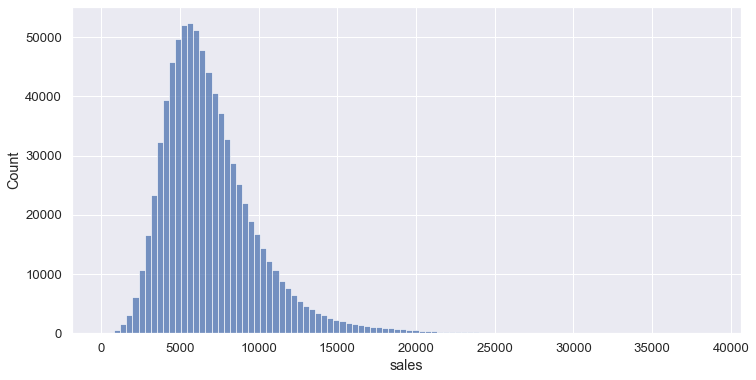

In [34]:
plt.figure(figsize=(12, 6))
sns.histplot(x='sales', bins= 100, data=df4);

### 4.1.2 Numerical Variable

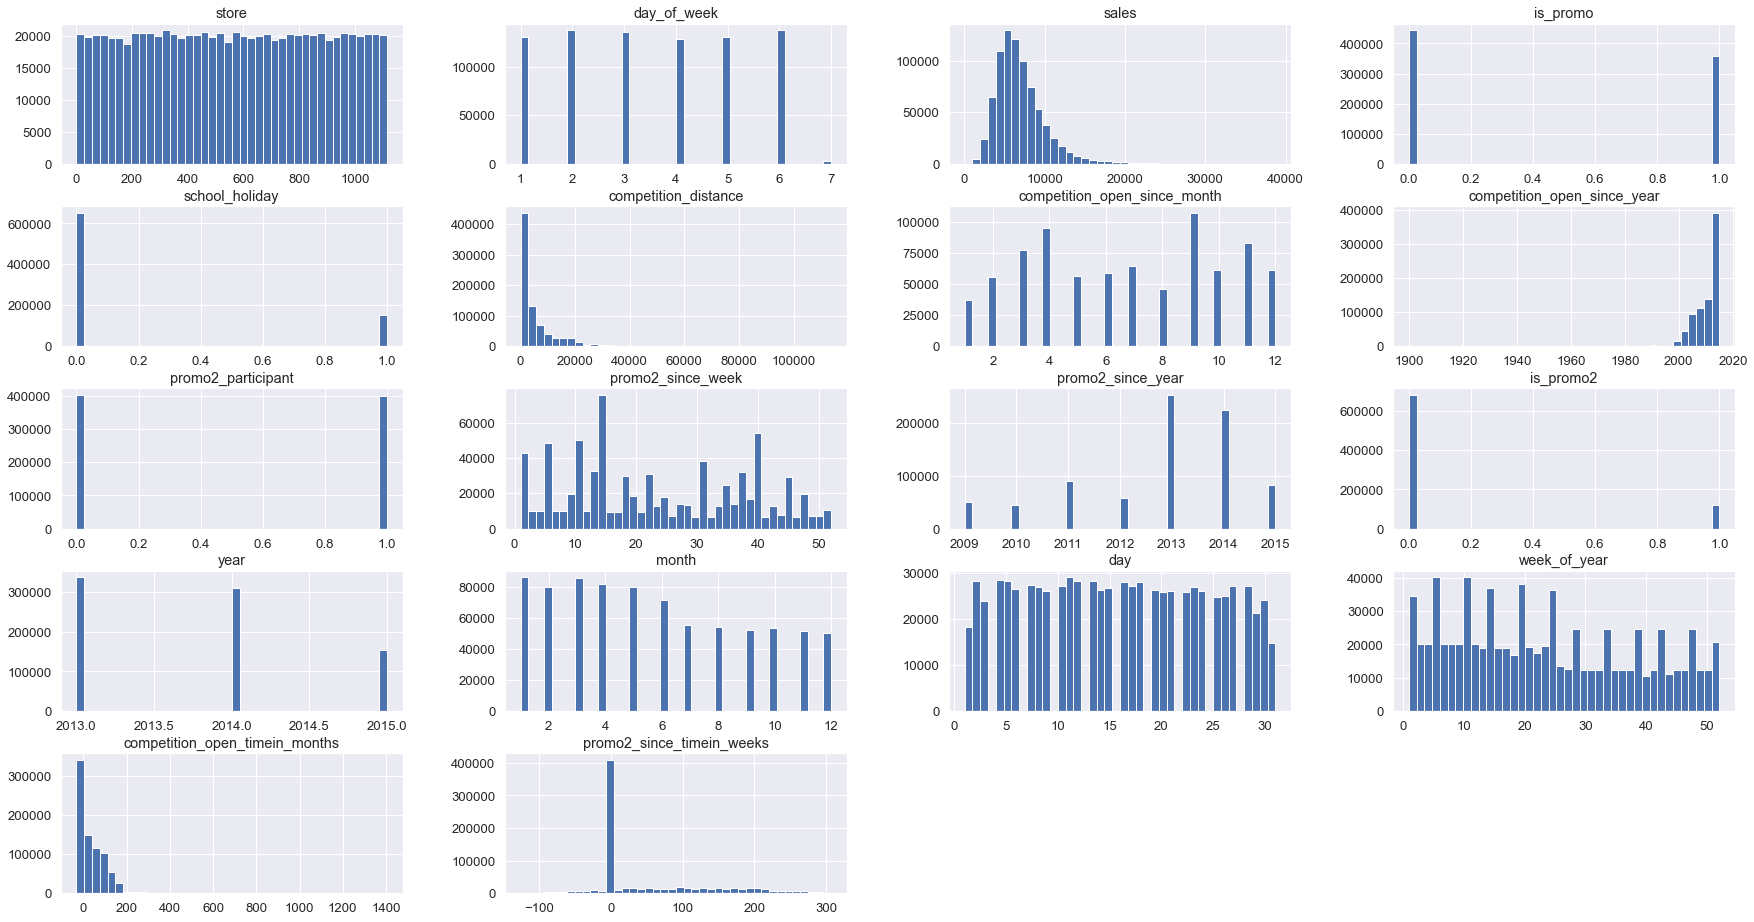

In [35]:
plt.rcParams['figure.figsize'] = [30, 16]
df_num2.hist(bins=40);

### 4.1.3 Categorical Variable

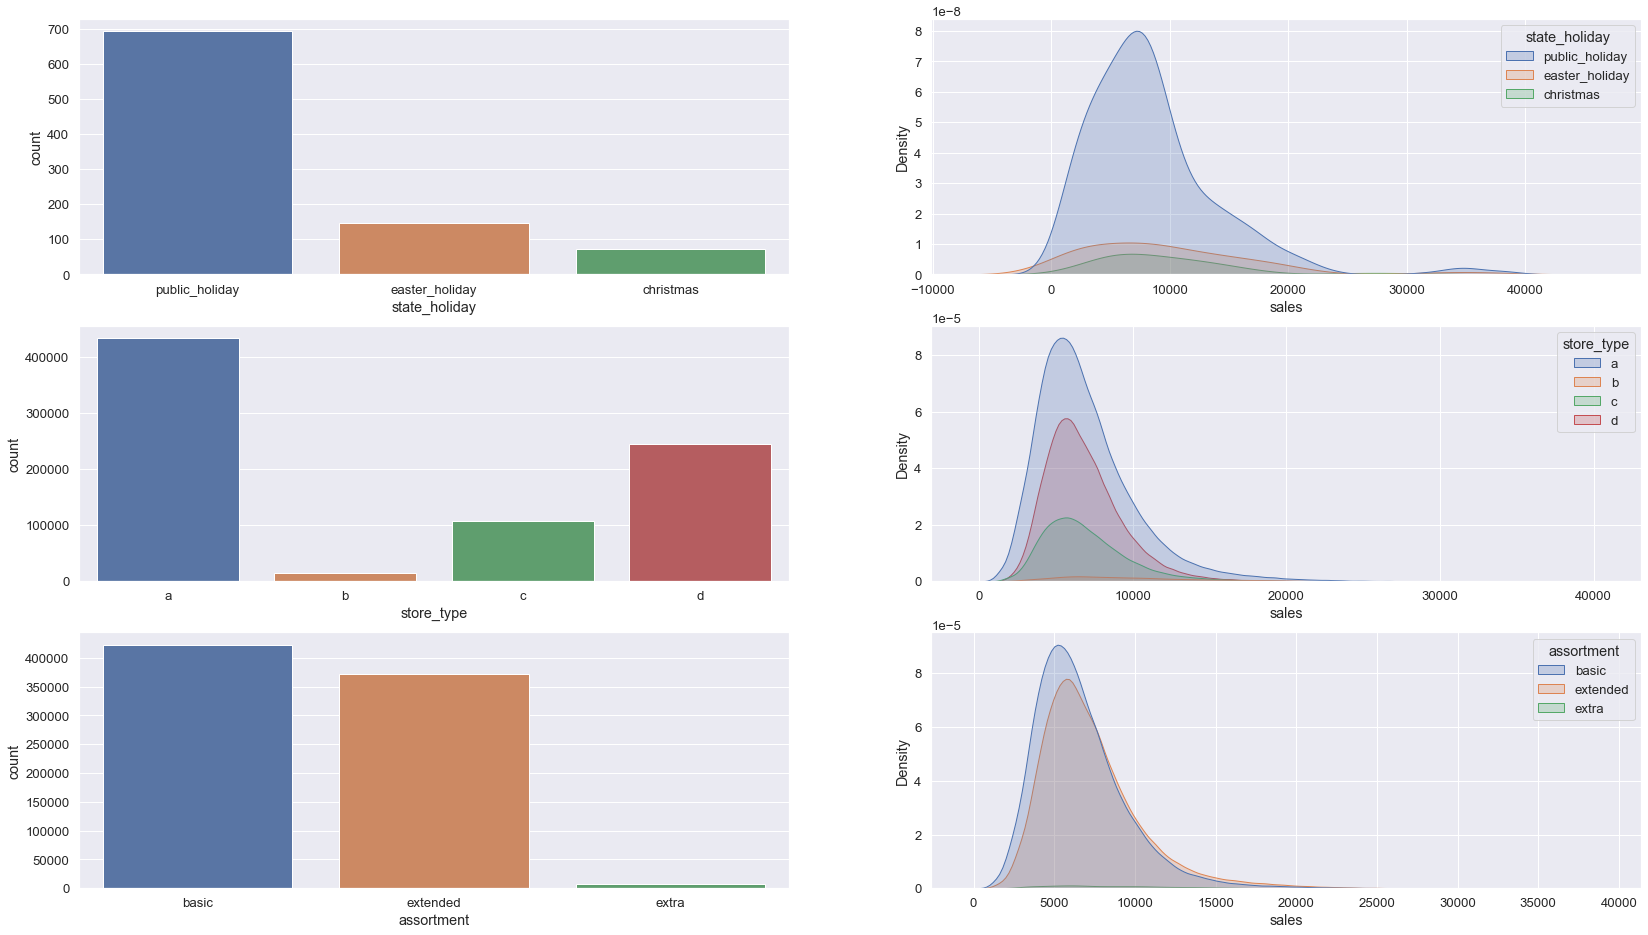

In [36]:
plt.figure(figsize= (28, 16))

# sales by 'state_holiday'
a = df4[df4['state_holiday']!='regular day']
plt.subplot(3,2,1)
sns.countplot(data=a, x='state_holiday', order=['public_holiday', 'easter_holiday', 'christmas'])

plt.subplot(3,2,2)
sns.kdeplot(data=a, x='sales', hue='state_holiday', hue_order=['public_holiday', 'easter_holiday', 'christmas'], fill=True)

# sales by 'store_type'
plt.subplot(3,2,3)
sns.countplot(data=df4, x='store_type', order=['a', 'b', 'c', 'd'])

plt.subplot(3,2,4)
sns.kdeplot(data=df4, x="sales", hue="store_type", hue_order=['a', 'b', 'c', 'd'], fill=True)

# sales by 'assortment'
plt.subplot(3,2,5)
sns.countplot(data=df4, x='assortment', order=['basic', 'extended', 'extra'])

plt.subplot(3,2,6)
sns.kdeplot(data=df4, x="sales", hue="assortment", hue_order=['basic', 'extended', 'extra'], fill=True);

## 4.2 Bivariate Analysis

### **H1.**  On on average, stores with a wider assortment should sell more.
**True.** Stores with wider assortments sell more.

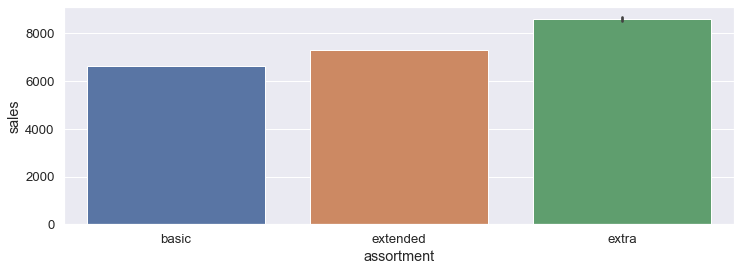

In [37]:
plt.figure(figsize= (12, 4))
sns.barplot(x='assortment', y='sales', data=df4, estimator=np.mean);

Our hypothesis has already been validated. But we will check the behavior over the weeks of the years.

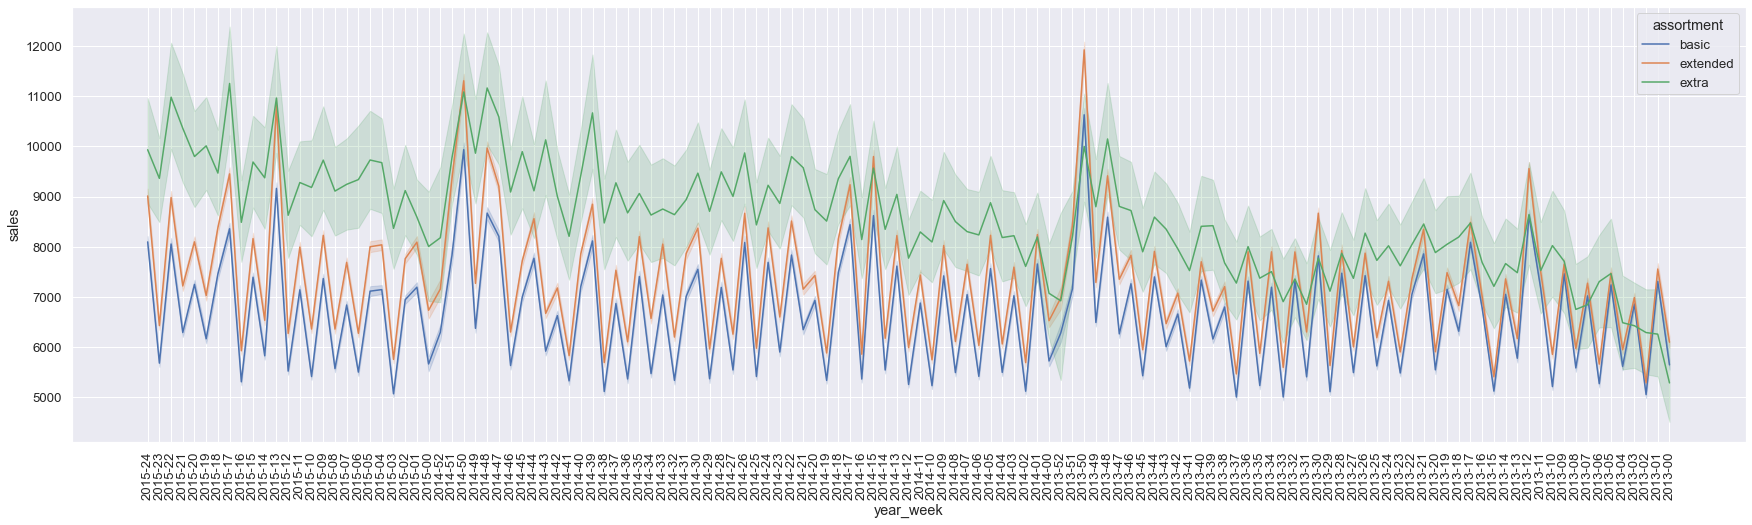

In [38]:
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()

plt.figure(figsize= (30, 8))
sns.lineplot(x='year_week', y='sales', hue='assortment', data=df4)
plt.xticks(rotation=90);

Basic and extended has a very similar behavior. In some weeks, the average sales of extended exceed those of extra.Note that the standard deviation of the extra is very high compared to the others, that is, the values vary greatly from the average. 

### **H2.** On avarange, stores with closer competitors should sell less.
**False.** Distance from competition does not have a a significant correlation with sales.

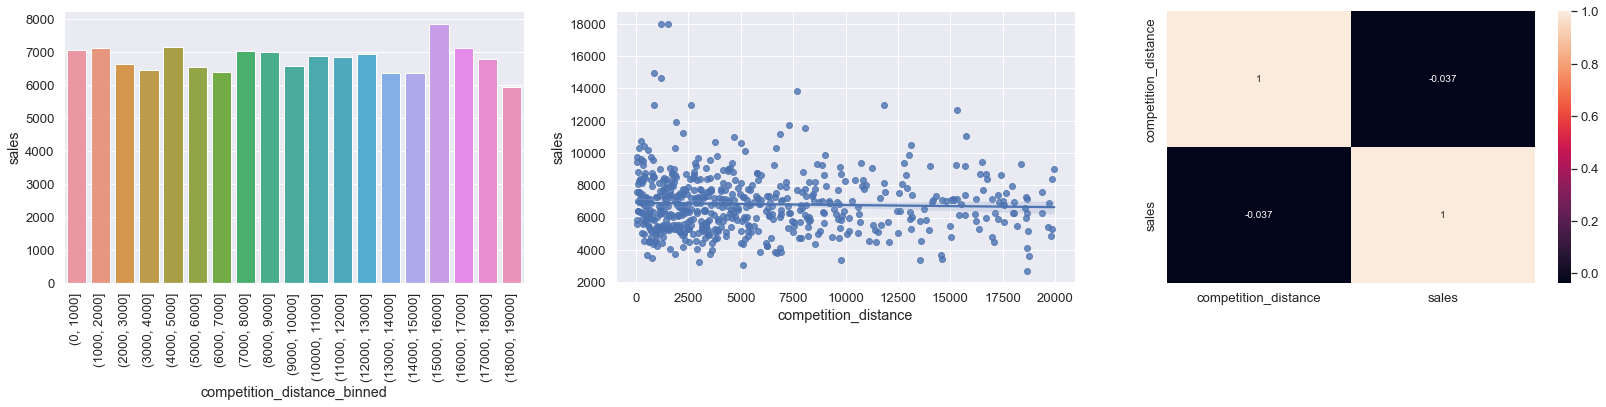

In [39]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()

plt.figure(figsize= (28, 5))

plt.subplot(1, 3, 1)
sns.barplot(x = 'competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
aux3 = aux1[aux1['competition_distance'] <= 20000]         # for better visualization (there are few values after 20000)
sns.regplot(x='competition_distance', y='sales', data=aux3)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Stores with long-term competitors (over 10 years) should sell more.

**True.** Stores with long-term competitors sell more.

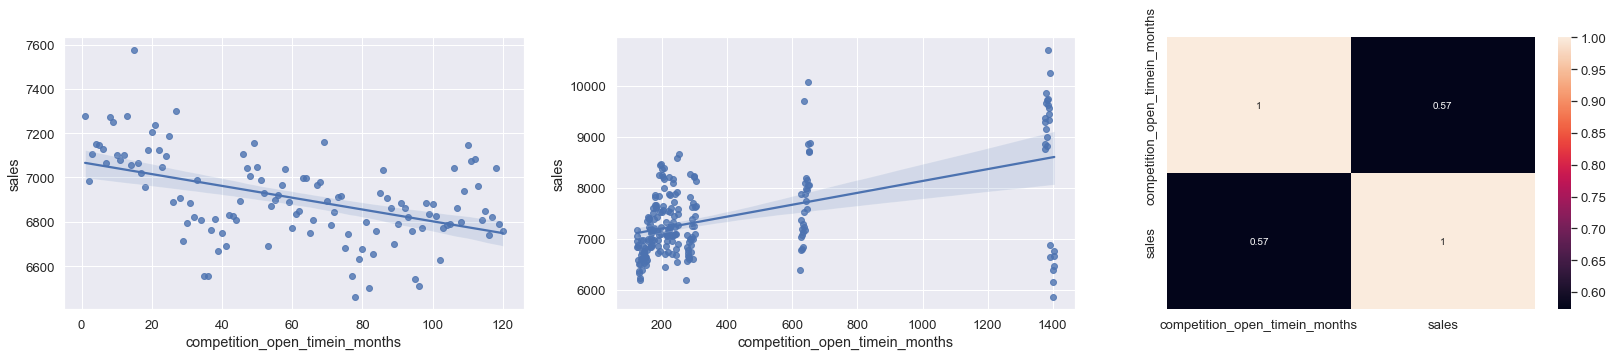

In [40]:
aux1 = df4[['competition_open_timein_months', 'sales']].groupby('competition_open_timein_months').mean().reset_index()
aux3 = aux1[(aux1['competition_open_timein_months'] > 0) & (aux1['competition_open_timein_months'] <= 120)]
aux4 = aux1[ aux1['competition_open_timein_months'] > 120]

plt.figure(figsize= (28, 5))

plt.subplot(1, 3, 1)
sns.regplot(x='competition_open_timein_months', y='sales', data=aux3)

plt.subplot(1, 3, 2)
sns.regplot(x='competition_open_timein_months', y='sales', data=aux4)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.**  On on average, stores with active promotions should sell more.
**True.** Stores with active promotions sell 38.56% more than stores with no promotion.

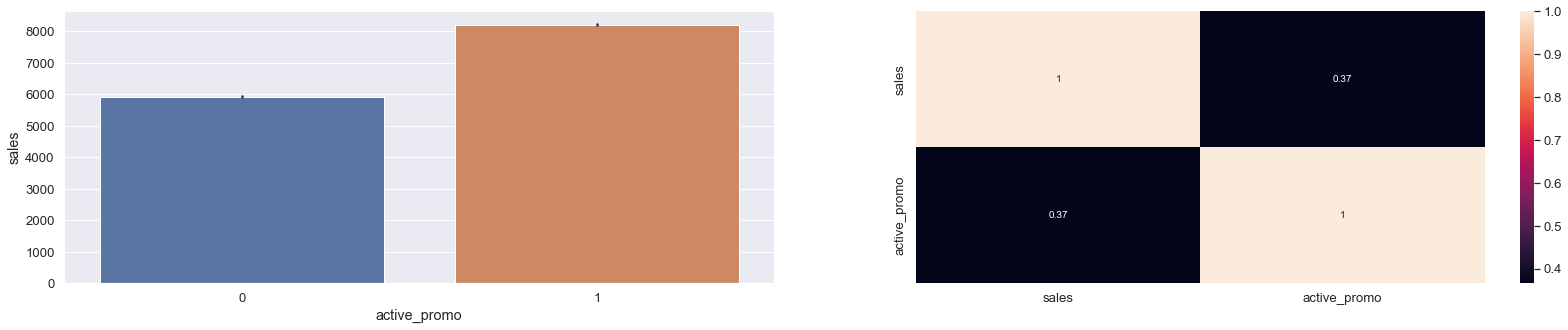

In [41]:
# is_promo  - indicates whether a store is running a promo (other than promo2) on that day
# is_promo2 - indicates whether a store is running a promo2 on that day 
# promo2 is a continuing and consecutive promotion for some stores
aux1 = df4[['store', 'sales', 'is_promo', 'is_promo2']].copy()
aux1['active_promo'] = aux1[['is_promo', 'is_promo2']].apply(lambda x: 0 if (x['is_promo'] == 0 & x['is_promo2']== 0) else 
                                                                       1, axis=1)

plt.figure(figsize= (28, 5))

plt.subplot(1, 2, 1)
sns.barplot(x = 'active_promo', y='sales', data=aux1);

plt.subplot(1, 2, 2)
sns.heatmap(aux1[['sales', 'active_promo']].corr(method='pearson'), annot=True);

In [42]:
aux2 = (aux1.groupby('active_promo').agg(qty_stores = ('store', 'nunique'), avg_sales = ('sales', 'mean'))).reset_index()
display(aux2)

active_promo = aux2.iloc[0,2]
no_promo     = aux2.iloc[1,2]

percentage = abs(((active_promo - no_promo) / no_promo)*100)
print(f' Stores with active promotions sell {percentage:.2f}% more than stores with no promotions.')

,active_promo,qty_stores,avg_sales
0,0,1115,5931.13
1,1,1115,8218.37


 Stores with active promotions sell 27.83% more than stores with no promotions.


### **H5.**  Stores with longer active promo2 should sell more.
**True.** The longer the time in promo2 the higher the average sales.

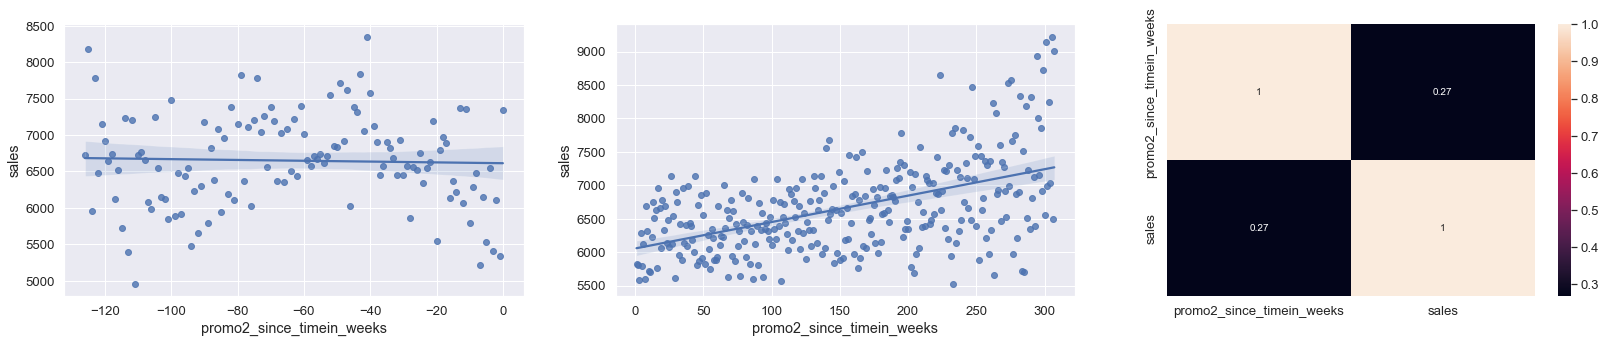

In [43]:
aux1 = df4[['promo2_since_timein_weeks', 'sales']].groupby('promo2_since_timein_weeks').mean().reset_index()

aux2 = aux1[aux1['promo2_since_timein_weeks'] >  0] 
aux3 = aux1[aux1['promo2_since_timein_weeks'] <= 0] 

plt.figure(figsize= (28, 5))

plt.subplot(1, 3, 1)
sns.regplot(x='promo2_since_timein_weeks', y='sales', data=aux3)

plt.subplot(1, 3, 2)
sns.regplot(x='promo2_since_timein_weeks', y='sales', data=aux2)

plt.subplot(1, 3, 3) 
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## -- note:
# negative values for promo2_since_timein_weeks means that promotion happened after sales register

For the positive values of 'promo2_since_timein_weeks' it is clear from the plot that the longer the time in prom2 the higher the sales, confirming our hypothesis. 

Negative values for 'competition_open_timein_months' means that the competition opened after the sales, and is interesting to take into consideration, when you have marketing actions about something that will happen.

### **H6.** On average, stores that besides continued promotion, also are running another promotion, sell more than stores that are running only the continued promotion.  
**True.** Stores that besides continued and consecutive promotion, also are running another promotion, sell 41.70% more than stores that are running only the continued and consecutive promotion.


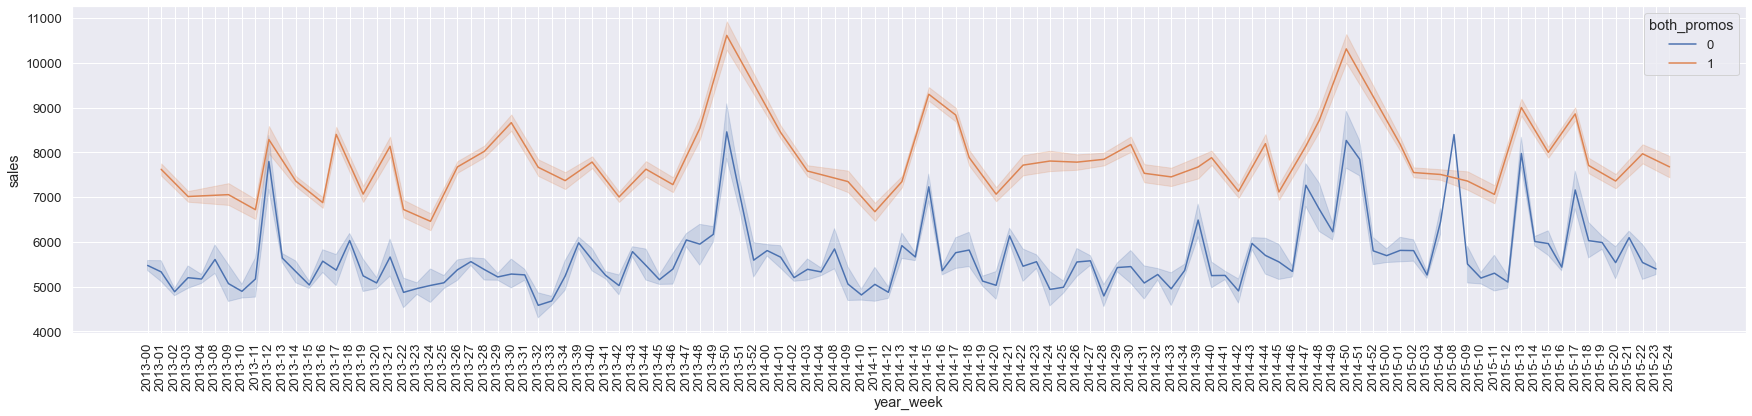

In [44]:
# is_promo  - indicates whether a store is running a promo (other than promo2) on that day.
# is_promo2 - indicates whether a store is running a promo2 on that day (promo2 is a continuing and 
#             consecutive promotion for some stores

aux1 = df4[df4['is_promo2']==1][['store', 
                                 'sales', 
                                 'is_promo', 
                                 'is_promo2', 
                                 'year_week']].sort_values('year_week', 
                                                           ascending=True).copy().rename(columns={'is_promo': 'promos'})

aux1['both_promos'] = aux1['promos'].apply(lambda x: 1 if x == 1 else 0 )

plt.figure(figsize= (30, 6))
sns.lineplot(x='year_week', y='sales', hue='both_promos', data=aux1)
plt.xticks(rotation=90);

In [45]:
aux2 = (aux1.groupby('both_promos').agg(qty_stores = ('store', 'nunique'), avg_sales  = ('sales', 'mean'))).reset_index()
display(aux2)

both_promos = aux2.iloc[0,2]
just_promo2 = aux2.iloc[1,2]

percentage = abs(((both_promos - just_promo2) / just_promo2)*100)
print(f' Stores that besides continued and consecutive promotion, also are running another promotion, sell {percentage:.2f}% more than stores that are running only the continued and consecutive promotion.')

,both_promos,qty_stores,avg_sales
0,0,571,5501.37
1,1,571,7795.24


 Stores that besides continued and consecutive promotion, also are running another promotion, sell 29.43% more than stores that are running only the continued and consecutive promotion.


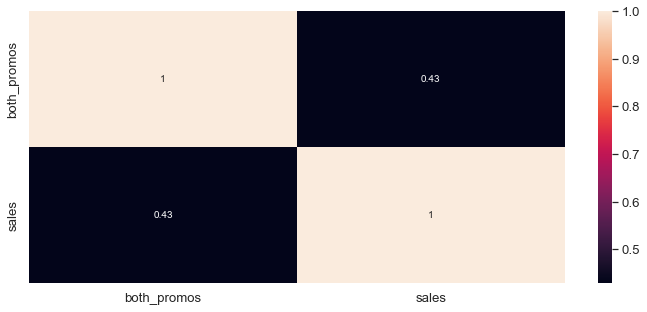

In [46]:
plt.figure(figsize= (12, 5))
sns.heatmap(aux1[['both_promos', 'sales']].corr(method='pearson'), annot=True);

### **H7.** Every year, stores open during the Christmas holiday are expected to sell more on average than during other holidays.
**False.** In 2014 the Christmas holiday sold more than the other holidays, but this did not occur in 2013.

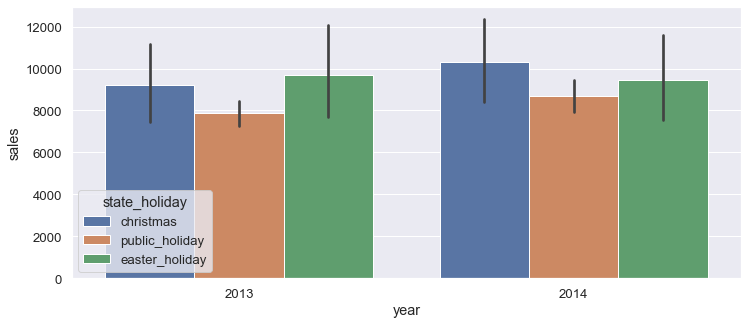

In [47]:
aux1 = df4[(df4['state_holiday'] != 'regular_day') & (df4['year'] != 2015)][['sales', 'state_holiday', 'year']].copy()

plt.figure(figsize= (12, 5))
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux1);

### **H8.** Stores should sell more over years.
**False.** From 2013 to 2014, sales decreased $122071188.00 which represents -5.60%.

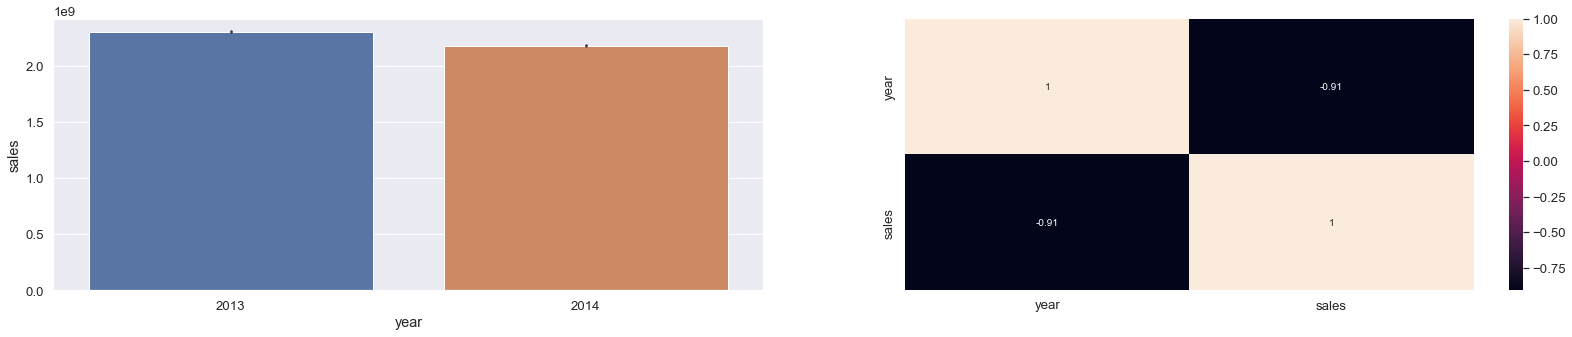

In [48]:
# leaving aside the year 2015 as we have data only for half of the year
aux1 = df4[df4['year'] != 2015][['year','sales', 'store']].copy()

plt.figure(figsize= (28, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='year', y='sales', data=aux1, estimator=np.sum);

aux2 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1, 2, 2) 
sns.heatmap(aux2.corr(method='pearson'), annot=True);

In [49]:
aux2 = (aux1.groupby('year').agg(qty_stores = ('store', 'nunique'), sum_sales = ('sales', 'sum'))).reset_index()
display(aux2)

sales2013 = aux2.iloc[0,2]
sales2014 = aux2.iloc[1,2]

percentage = abs(((sales2013 - sales2014) / sales2014)*100)
print(f'From 2013 to 2014, sales decreased ${(sales2013 - sales2014):.2f} which represents -{percentage:.2f}%')

,year,qty_stores,sum_sales
0,2013,1115,2302876084
1,2014,1115,2180804896


From 2013 to 2014, sales decreased $122071188.00 which represents -5.60%


### **H9.** Stores should sell more in the second half of the year.
**False.** In 2013 stores sold more in the second half, but in 2014 they did not.

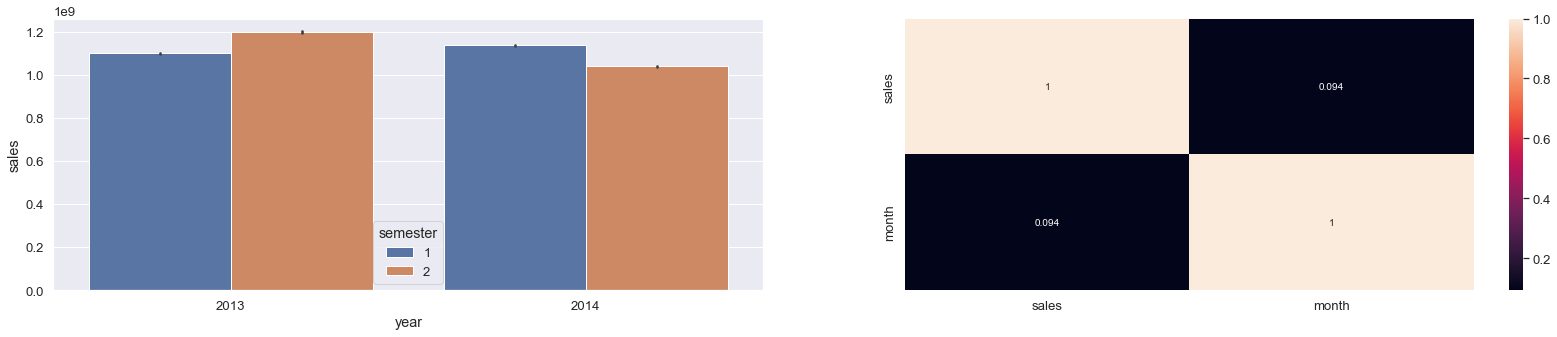

In [50]:
# leaving aside the year 2015 as we have data only for half of the year
aux1 = df4[df4['year'] != 2015][['year', 'month', 'sales', 'store']].copy()

aux1['semester'] = aux1['month'].apply(lambda x: 1 if x <= 6 else 2)

plt.figure(figsize= (28, 5))

plt.subplot(1, 2, 1) 
sns.barplot(x='year', y='sales', hue='semester', data=aux1, estimator=np.sum)

plt.subplot(1, 2, 2) 
sns.heatmap(aux1[['sales', 'month']].corr(method='pearson'), annot=True);

### **H10.** On avarange, stores should sell more after the 10th of each month.
**False.** The stores sell 7.78% more before the 10th.

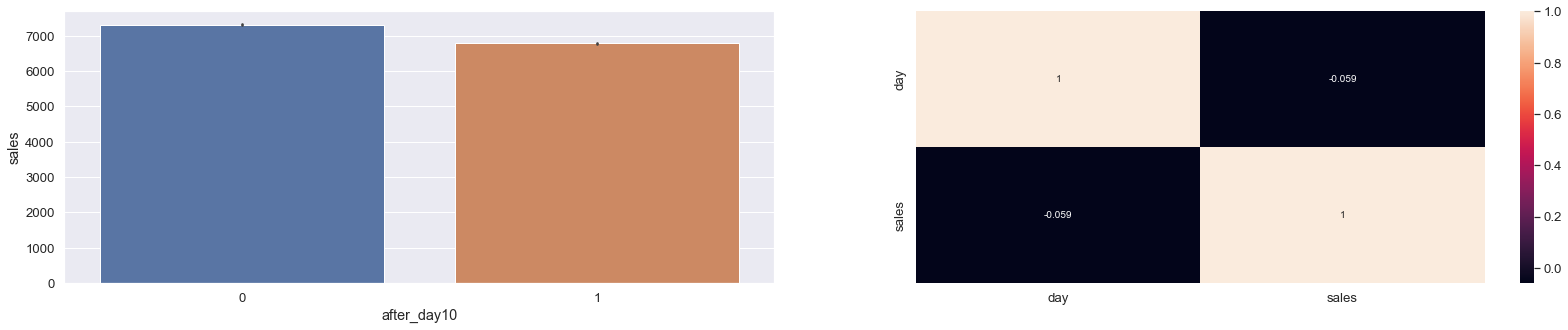

In [51]:
aux1 = df4[['day', 'sales']].copy()

aux1['after_day10'] = aux1['day'].apply(lambda x: 0 if x <= 10 else 1)

plt.figure(figsize= (28, 5))

plt.subplot(1, 2, 1) 
sns.barplot(x='after_day10', y='sales', data=aux1)

plt.subplot(1, 2, 2) 
sns.heatmap(aux1[['day', 'sales']].corr(method='pearson'), annot=True);

In [52]:
aux2 = (aux1.groupby('after_day10').agg(avg_sales = ('sales', 'mean'))).reset_index()
display(aux2)

before_day10 = aux2.iloc[0,1]
after_day10  = aux2.iloc[1,1]

percentage = abs(((before_day10 - after_day10 ) / after_day10 )*100)
print(f'The stores sell {percentage:.2f}% more before the 10th.')

,after_day10,avg_sales
0,0,7310.60
1,1,6782.81


The stores sell 7.78% more before the 10th.


### **H11.** On avarange, stores should sell less on weekends.
**True.** The stores sell 20.64% less on weekends.

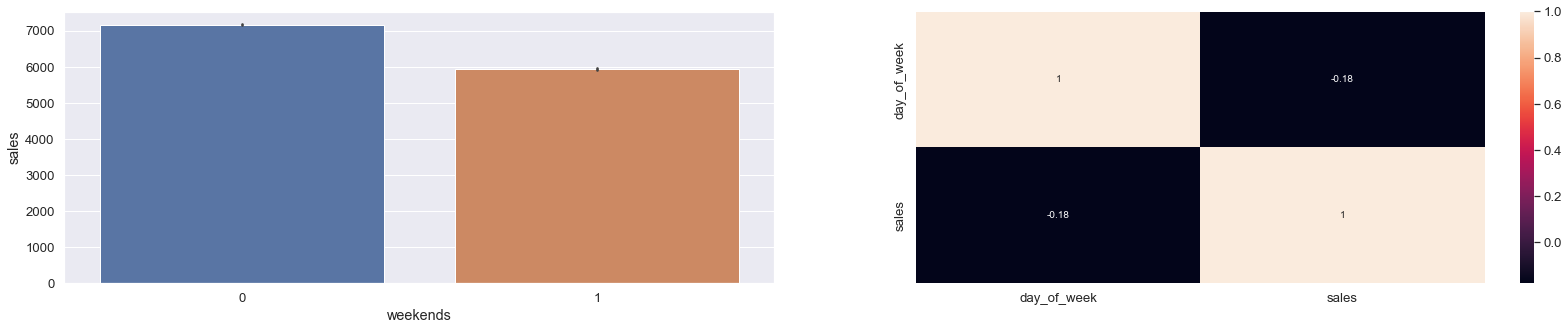

In [53]:
aux1 = df4[['day_of_week', 'sales', 'store']].copy()
aux1['weekends'] = aux1['day_of_week'].apply(lambda x: 0 if x < 6 else 1)

plt.figure(figsize= (28, 5))

plt.subplot(1, 2, 1) 
sns.barplot(x='weekends', y='sales', data=aux1)

plt.subplot(1, 2, 2) 
sns.heatmap(aux1[['day_of_week', 'sales']].corr(method='pearson'), annot=True);

In [54]:
aux2 = (aux1.groupby('weekends').agg(avg_sales = ('sales', 'mean'))).reset_index()
display(aux2)

weekend  = aux2.iloc[0,1]
weekdays = aux2.iloc[1,1]

percentage = abs(((weekdays - weekend) / weekend)*100)
print(f'The stores sell {percentage:.2f}% less on weekends.')

,weekends,avg_sales
0,0,7168.98
1,1,5942.39


The stores sell 17.11% less on weekends.


### **H12**. On avarange, stores should sell less during school holidays.
**False.** The stores sell 3.62% more when it is schooll holidays.

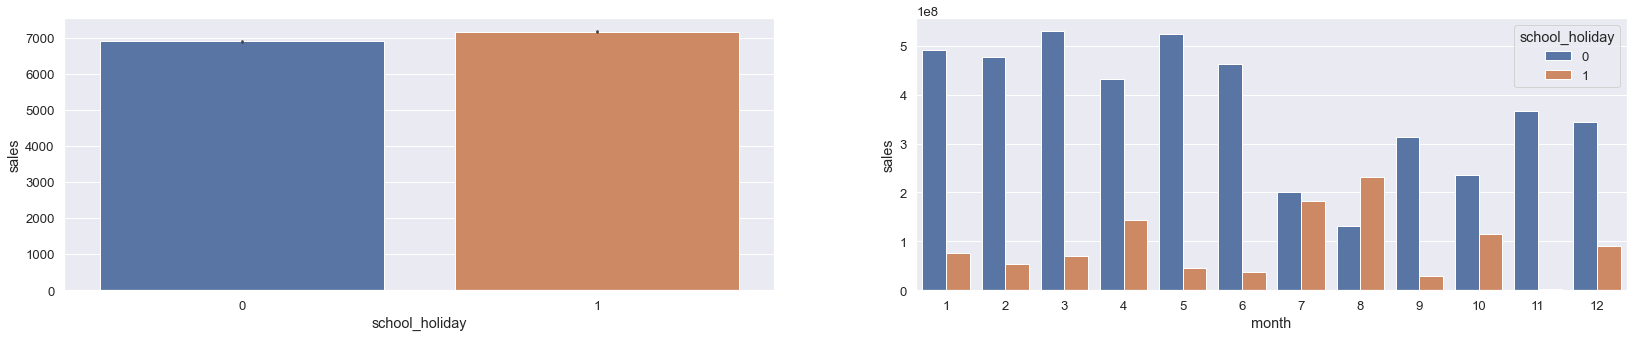

In [55]:
plt.figure(figsize= (28, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='school_holiday', y='sales', data=df4);

plt.subplot(1, 2, 2)
aux1 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux1);

In [56]:
aux1 = df4[['school_holiday',
            'sales']].groupby(['school_holiday']).agg(num_sales = ('sales', 'count'), 
                                                      avg_sales = ('sales', 'mean')).reset_index()
display(aux1)

no_school_holiday = aux1.iloc[0,2]
school_holiday    = aux1.iloc[1,2]

percentage = abs(((school_holiday - no_school_holiday) / no_school_holiday)*100)
print(f'The stores sell {percentage:.2f}% more when it is school holidays.')

,school_holiday,num_sales,avg_sales
0,0,652801,6905.40
1,1,150141,7164.98


The stores sell 3.76% more when it is school holidays.


## 4.3 Multivariate Analysis

The goal is not only to see the correlation between the response variable and the predictors, but also between the predictors themselves, to reduce the dimensionality of the model. 
If one variable is highly correlated with another you can take one of them out to reduce the dimensionality of the model. 

### 4.3.1 Numerical Attributes

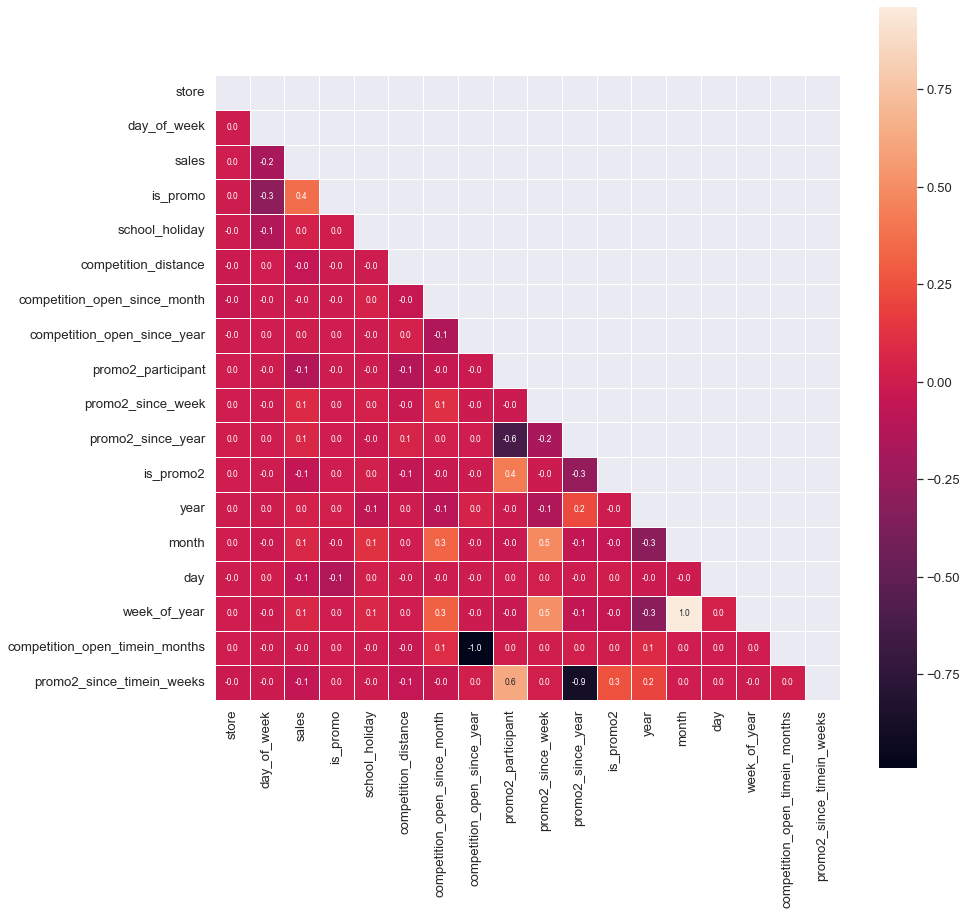

In [57]:
corr = df_num2.corr(method='pearson' )

corr_mask = np.triu(corr)

plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True, annot_kws={'fontsize':'small'}, fmt='.1f', linewidths=0.8, square=True, mask=corr_mask);

### 4.3.2 Categorical Attributes

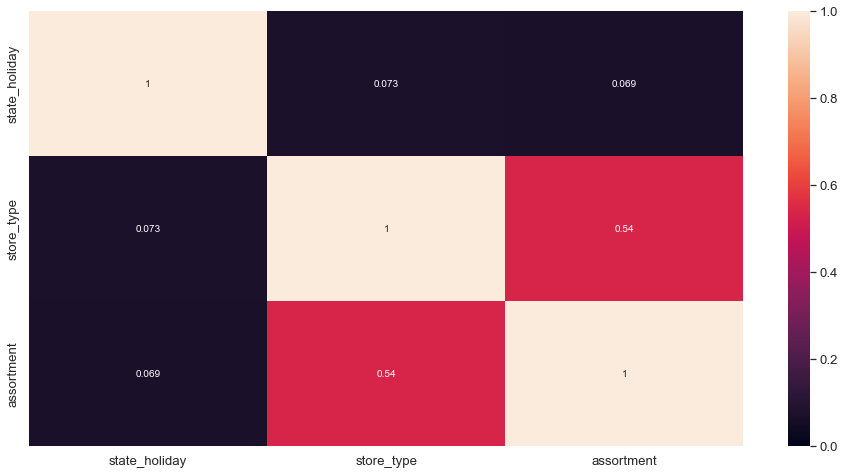

In [58]:
# calculating Cramér's V 
cat = df_cat2.copy()
cat_list = ['state_holiday', 'store_type', 'assortment']
cat_dic = {}


for c1 in cat_list:
    for c2 in cat_list:
        v = cramer_v(cat[c1], cat[c2]) # the cramer_v function is on Helper Functions

        if cat_list.index(c2) == 0:
            cat_dic[c1] = []
            cat_dic[c1].append(v)
        else:
            cat_dic[c1].append(v)


t = pd.DataFrame(cat_dic)
t.set_index(t.columns, inplace=True)

plt.figure(figsize=(16, 8))
sns.heatmap(t, vmin=0, vmax=1, annot=True);

# 5.0 DATA PREPARATION

In [59]:
df5 = df3.copy()

## 5.1 Normalization

Normalization works well when our data has very low skewness, having only kurtosis.   
Going back to our univariate exploratory analysis, we do not have any data with a normal distribution, so we will not apply normalization.  

## 5.2 Rescaling

MinMaxScaler subtracts the minimum value in the column and then divides by the difference between the original maximum and the original minimum. It is clear that MinMaxScaler is very sensitive to outliers, making this data very close to zero.   
RobustScaler standardizes a characteristic by removing the median and dividing each characteristic by the interquartile range. Using RobustScaler we can reduce the influence of outliers.    
So let's use the RobustScaler for data with outliers and MinMaxScaler for the others.

In [60]:
mms = MinMaxScaler()
rs  = RobustScaler()

df5['year'] = mms.fit_transform(df5[['year']])
#pickle.dump(mms, open('parameters/rescaling_year_c01.pkl', 'wb'))

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
#pickle.dump(rs, open('parameters/rescaling_competition_distance_c01.pkl', 'wb'))

df5['competition_open_since_year'] = mms.fit_transform(df5[['competition_open_since_year']].values)
#pickle.dump(mms, open('parameters/rescaling_competition_open_since_year_c01.pkl', 'wb'))

df5['competition_open_since_month'] = mms.fit_transform(df5[['competition_open_since_month']].values)
#pickle.dump(mms, open('parameters/rescaling_competition_open_since_month_c01.pkl', 'wb'))

df5['competition_open_timein_months'] = rs.fit_transform(df5[['competition_open_timein_months']].values)
#pickle.dump(rs, open('parameters/rescaling_competition_open_timein_months_c01.pkl', 'wb'))

df5['promo2_since_timein_weeks'] = mms.fit_transform(df5[['promo2_since_timein_weeks']].values)
#pickle.dump(mms, open('parameters/rescaling_promo2_since_timein_weeks_c01.pkl', 'wb'))

df5['promo2_since_year'] = mms.fit_transform(df5[['promo2_since_year']].values)
#pickle.dump(mms, open('parameters/rescaling_promo2_since_year_c01.pkl', 'wb'))

df5['promo2_since_timein_weeks'] = mms.fit_transform(df5[['promo2_since_timein_weeks']].values)
#pickle.dump(mms, open('parameters/rescaling_promo2_since_timein_weeks_c01.pkl', 'wb'))

## 5.3 Transforming

### 5.3.1 Encoding

With One Hot Encoding each label becomes a column - we will use in 'state'_holiday because it is a variable that gives the idea of state (something that changes).    
With Ordinal Encoding each label becomes a value in a hierarchy -  we will in 'assortment' because it is a variable that has a hierarchy, the type of assortment represents the level of product variety in the store.     
With Label Encoding each label becomes a value in a range without hierarchical relationship - we will  in 'store_type' because it is a variable that we are not sure if it has a hierarchy or not.   

In [61]:
le = LabelEncoder()

# state_holiday - one hot enconding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - label enconding 
df5['store_type'] = le.fit_transform(df5['store_type'])
#pickle.dump(le, open('parameters/transforming_store_type_c01.pkl', 'wb'))

# assortment - ordinal enconding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

We will use the logarithmic transformation to make the response variable have a normal distribution.

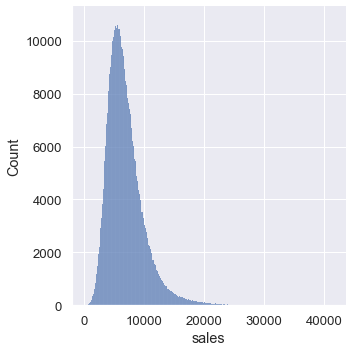

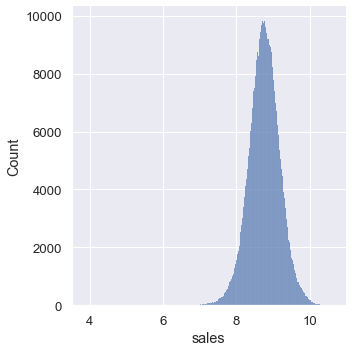

In [62]:
sns.displot(x='sales', data=df5)

df5['sales'] = np.log1p(df5['sales'])
sns.displot(x='sales', data=df5);

### 5.3.3 Nature Transformation

In order to respect the cyclical nature of time variables such as day, day of the week, week, and month we will apply cyclical transformations of sine and cosine type.

In [63]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12))) 
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12))) 

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52))) 
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52))) 

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30))) 
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7))) 
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# 6.0 FEATURE SELECTION

In [64]:
df6 = df5.copy()

In [65]:
# deleting columns that derived from other features
dropcols = ['month', 'week_of_year', 'year_week', 'day', 'day_of_week', 'promo2_since', 'competition_open_since']
df6 = df6.drop(dropcols, axis=1)

# 6.1 Training and Test dataset

In [66]:
# Checking 'date' intervals
first_date = df6['date'].min()
last_date  = df6['date'].max()
sixweeks_before = last_date - datetime.timedelta(days=6*7)

print(first_date, '-> First date')
print(last_date,  '-> Last date' )
print(sixweeks_before, '-> Six weeks before last date')

2013-01-01 00:00:00 -> First date
2015-07-31 00:00:00 -> Last date
2015-06-19 00:00:00 -> Six weeks before last date


In [67]:
# Training Dataset before feature selection
X_train_bfs = df6[df6['date'] < sixweeks_before]
y_train = X_train_bfs['sales']

# Test Dataset before feature selection
X_test_bfs = df6[df6['date'] >= sixweeks_before]
y_test = X_test_bfs['sales']

print(f"Training Min Date: {df_train['date'].min()}")
print(f"Training Max Date: {df_train['date'].max()}")
print()
print(f"Test Min Date: {df_test['date'].min()}")
print(f"Test Max Date: {df_test['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta Features Selection

In [68]:
## training and test dataset for Boruta
#X_train_b = X_train.drop(['date', 'sales'], axis=1).values
#y_train_b = y_train.values 
#
## defining Radom Forest Regressor
#rf = RandomForestRegressor(n_jobs=-1) #pararel processing
#
## defining Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_b, y_train_b)

In [69]:
#cols_selected_boruta = boruta.support_.tolist()                                         # list of features boruta selected in boolean format
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)                                    # deleting cols from X_train to read next step
#
## features Selected from Boruta
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected_boruta].columns.to_list()       # list of columns boruta selected
#
## features not Selected from Boruta
#cols_notselected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))  # list of columns boruta did not select

## 6.2 Manual Features Selection

In [70]:
# adding columns to those selected by the boruta

cols_selected = [
    'store',
    'is_promo',
    'is_promo2',  # added manually
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2_participant',
    'promo2_since_week',
    'promo2_since_year',
    'competition_open_timein_months',
    'promo2_since_timein_weeks',
    'month_cos',
    'week_of_year_sin',  # added manually
    'week_of_year_cos',
    'day_sin',
    'day_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'year']  # added manually

# features to add
features_to_add = ['date', 'sales']

cols_selected_full = cols_selected.copy()
cols_selected_full.extend(features_to_add)
cols_selected_full

['store',
 'is_promo',
 'is_promo2',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2_participant',
 'promo2_since_week',
 'promo2_since_year',
 'competition_open_timein_months',
 'promo2_since_timein_weeks',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'year',
 'date',
 'sales']

# 7.0 MACHINE LEARNING

Given the business problem presented, we then have a regression problem since the response variable must be a real value (in our case, the value of sales for each store).  
To solve it, first, we will use the average, which is intended to serve as a baseline for comparing the performance of the other algorithms. Following Occam's heuristic that simple theories are preferable to complex ones, we will use two linear models, the Linear Regression and the Regularized Linear Regression. If the linear models perform well, we can assume that the data has linear behavior, and complex models are not necessary. Then we will use the nonlinear algorithms, the Random Forest Regressor and the XGBoost Regressor.

In [71]:
X_train = X_train_bfs[cols_selected]
X_test  = X_test_bfs[cols_selected]

# time series data preparation for cross validation
X_training = X_train_bfs[cols_selected_full]

## 7.1 Average

In [72]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# creating prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_beseline = aux1['predictions']

# # performance - ml_error(model_name, y, yhat):
baseline_results = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_beseline))
baseline_results 

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.21,1835.14


### 7.1.2 Linear Regression

### 7.2.1 Single Performance

In [73]:
# model
lr = LinearRegression().fit(X_train, y_train)

# creating predicition
yhat_lr = lr.predict(X_test)

# performance - ml_error(model_name, y, yhat):
lr_results = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_results 

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1875.13,0.29,2708.52


### 7.1.2 Real Performance - Cross Validation

In [74]:
lr_results_cv = cross_validation(X_training, 5, 'Linear Regression', lr, verbose=False)
lr_results_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2040.76 +/- 267.47,0.3 +/- 0.01,2911.4 +/- 396.61


## 7.3 Linear Regression Regularized - Lasso

### 7.3.1 Single Performance

In [75]:
# model
lrr = Lasso().fit(X_train, y_train)

# creating predicition
yhat_lrr = lrr.predict(X_test)

# performance - ml_error(model_name, y, yhat):
lrr_results = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_results

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,2198.58,0.34,3110.51


### 7.3.2 Real Performance - Cross Validation

In [76]:
lrr_results_cv = cross_validation(X_training, 5, 'Linear Regression - Lasso', lrr, verbose=False)
lrr_results_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2388.68 +/- 398.48,0.34 +/- 0.01,3369.37 +/- 567.55


## 7.4 Random Forest Regressor

### 7.4.1 Single Performance

In [77]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, y_train)

# creating predicition
yhat_rf = rf.predict(X_test)

# performance - ml_error(model_name, y, yhat):
rf_results = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_results

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.13,0.10,1007.92


### 7.4.2 Real Performance - Cross Validation

In [78]:
rf_results_cv = cross_validation(X_training, 5, 'Random Forest Regressor', rf, verbose=False)
rf_results_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.18 +/- 220.28,0.12 +/- 0.02,1254.36 +/- 320.57


## 7.5 XGBoost  Regressor

### 7.5.1 Single Performance

In [79]:
# model
xgb = XGBRegressor(objective='reg:squarederror',
                   n_estimators=1000, 
                   eta=0.01, 
                   max_depth=10,
                   subsample=0.7,
                   colsample_bytree=0.9).fit(X_train, y_train)

# creating predicition
yhat_xgb = xgb.predict(X_test)

# performance - ml_error(model_name, y, yhat):
xgb_results = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_results

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,910.21,0.13,1343.53


### 7.5.2 Real Performance - Cross Validation

In [80]:
xgb_results_cv = cross_validation(X_training, 5, 'XGBoost Regressor', xgb, verbose=False)
xgb_results_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1060.91 +/- 166.35,0.15 +/- 0.01,1532.42 +/- 227.07


## 7.6. Performance Comparison

### 7.6.1 Single Performance

In [81]:
modelling_result = pd.concat([baseline_results, lr_results, lrr_results, rf_results, xgb_results])
modelling_result.sort_values('RMSE') 

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.13,0.10,1007.92
0,XGBoost Regressor,910.21,0.13,1343.53
0,Average Model,1354.80,0.21,1835.14
0,Linear Regression,1875.13,0.29,2708.52
0,Linear Regression - Lasso,2198.58,0.34,3110.51


### 7.6.2 Real Performance - Cross Validation

In [82]:
modelling_result_cv = pd.concat([lr_results_cv, lrr_results_cv, rf_results_cv, xgb_results_cv] )
modelling_result_cv.sort_values(by='RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.18 +/- 220.28,0.12 +/- 0.02,1254.36 +/- 320.57
0,XGBoost Regressor,1060.91 +/- 166.35,0.15 +/- 0.01,1532.42 +/- 227.07
0,Linear Regression,2040.76 +/- 267.47,0.3 +/- 0.01,2911.4 +/- 396.61
0,Linear Regression - Lasso,2388.68 +/- 398.48,0.34 +/- 0.01,3369.37 +/- 567.55


As the difference in performance between Random Forest and  XGBoost are not great, we will move on to hyperparameter fine tuning with XGBoost. A Random Forest model can get very large, requiring a lot of space. This is just the nature of a Random Forest, because all the trees you have trained must be stored, with all their nodes. Think about the company paying servers per hour for this model. This performance difference may not compensate for the price of storage.

# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [83]:
#param_dict = {'n_estimators': [1000, 1700, 2500, 3000, 3500],
#              'eta': [0.01, 0.03],
#              'max_depth': [3, 6, 9],
#              'subsample': [0.1, 0.5, 0.7],
#              'colsample_bytree': [0.3, 0.5, 0.8, 1],
#              'min_child_weight': [1, 3, 8, 15]}
#
#MAX_EVAL = 10

In [84]:
#final_result = pd.DataFrame()
#hyperparam_list = []
#
#for i in range(MAX_EVAL):
#    
#    # choose random param values
#    hp = {k: random.sample(v, 1)[0] for k, v in param_dict.items()}
#    
#    # print selected values
#    print(hp)
#    
#    #store in list
#    hyperparam_list.append(hp.copy())
#
#    # model
#    xgb = XGBRegressor(objective        = 'reg:squarederror',
#                       n_estimators     = hp['n_estimators'], 
#                       eta              = hp['eta'], 
#                       max_depth        = hp['max_depth'],
#                       subsample        = hp['subsample'],
#                       colsample_bytree = hp['colsample_bytree'],
#                       min_child_weight = hp['min_child_weight'])
#
#    
#    # performance
#    xgb_result = cross_validation(X_training, 5, 'XGBoost Regressor', xgb, verbose=True)
#    final_result = pd.concat([final_result, xgb_result])
#    
#final_result

## 8.2 Final Model

In [85]:
tuned_param_dict = {'n_estimators': 1700,
                     'eta': 0.03,
                     'max_depth': 9,
                     'subsample': 0.7,
                     'colsample_bytree': 0.5,
                     'min_child_weight': 15}

# model
xgb_tuned = XGBRegressor(objective        = 'reg:squarederror',
                         n_estimators     = tuned_param_dict['n_estimators'], 
                         eta              = tuned_param_dict['eta'], 
                         max_depth        = tuned_param_dict['max_depth'],
                         subsample        = tuned_param_dict['subsample'],
                         colsample_bytree = tuned_param_dict['colsample_bytree'],
                         min_child_weight = tuned_param_dict['min_child_weight']).fit(X_train, y_train)

# prediction
yhat_xgb_tuned = xgb_tuned.predict(X_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,638.68,0.09,928.49


In [86]:
# checking whether the model in most predictions is overestimating (-MPE) or underestimating (+MPE)
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
print(f'MPE: {mpe:.3f}')

MPE: -0.007


In [87]:
# saving XGB model tuned
# pickle.dump(xgb_tuned, open('models/model_xgb_tuned_c01.pkl', 'wb'))

# 9.0 ERROR INTERPRETATION

In [88]:
df9 = X_test_bfs[cols_selected_full].copy()

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [89]:
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df91_MAE = df9[['store', 
                 'sales', 
                 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],
                                                                                      x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df91_MAPE = df9[['store', 
                 'sales', 
                 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], 
                                                                                                 x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# merging to sum of predictions
df91_aux1 = pd.merge(df91_MAE, df91_MAPE, how='inner', on='store')
df92      = pd.merge(df91, df91_aux1, how='inner', on='store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario']  = df92['predictions'] + df92['MAE']

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [90]:
display(df92.sort_values('MAPE', ascending=True ).head())
display(df92.sort_values('MAPE', ascending=False).head())

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
258,259,553080.75,552546.57,553614.93,534.18,0.04
1088,1089,378653.53,378128.13,379178.94,525.40,0.05
989,990,236415.44,236099.91,236730.96,315.52,0.05
1096,1097,462740.09,462199.25,463280.94,540.84,0.05
380,381,329500.44,329028.30,329972.57,472.14,0.05


,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107188.53,103828.28,110548.78,3360.25,0.58
908,909,235533.48,227965.91,243101.06,7567.58,0.51
875,876,203286.39,199395.12,207177.66,3891.27,0.30
594,595,379086.94,375029.48,383144.40,4057.46,0.28
721,722,346635.03,344815.06,348455.01,1819.97,0.24


Looking beyond the overall performance, for some stores, the model achieved very good performance for others a poor performance. Let's plot this, for better visualization.

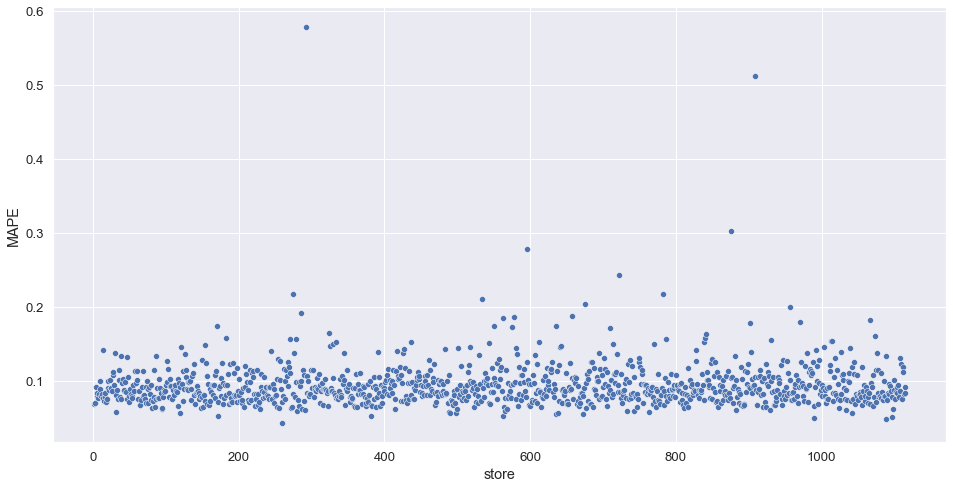

In [91]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x='store', y='MAPE', data=df92);

Looking at the individual stores, for most of them the model error was around 8% to 10%, very few stores had an error above 20%. In a next CRISP-DM cycle, one should try to improve this, sometimes even thinking of specific models for these stores. 

## 9.2 Total Performance

In [92]:
df93 = df92[['predictions', 
             'worst_scenario', 
             'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})

df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$285,707,584.00"
1,worst_scenario,"R$284,991,409.31"
2,best_scenario,"R$286,423,764.87"


In [93]:
df93 = df92[['predictions', 
             'worst_scenario', 
             'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})

df93['Values'] = (df93['Values']/1000000).round(2).astype(str) + ' MM'
df93

,Scenario,Values
0,predictions,285.71 MM
1,worst_scenario,284.99 MM
2,best_scenario,286.42 MM


## 9.3 Machine Learning Performance

In [94]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

The final performance of the model can be analyzed by these 4 plots below, showing the differences between predictions and actual values, the error rate - which can be used to find non-random errors, especially of time-related effects, and the error distribution - to detect violation of the normality assumption, and error for predictions - should show a random pattern of an error on either side of 0, if a point is far from most points, it may be an outlier value, there should be no recognizable pattern in the error plot. These error plots will be used for residual analysis, in a next cycle.

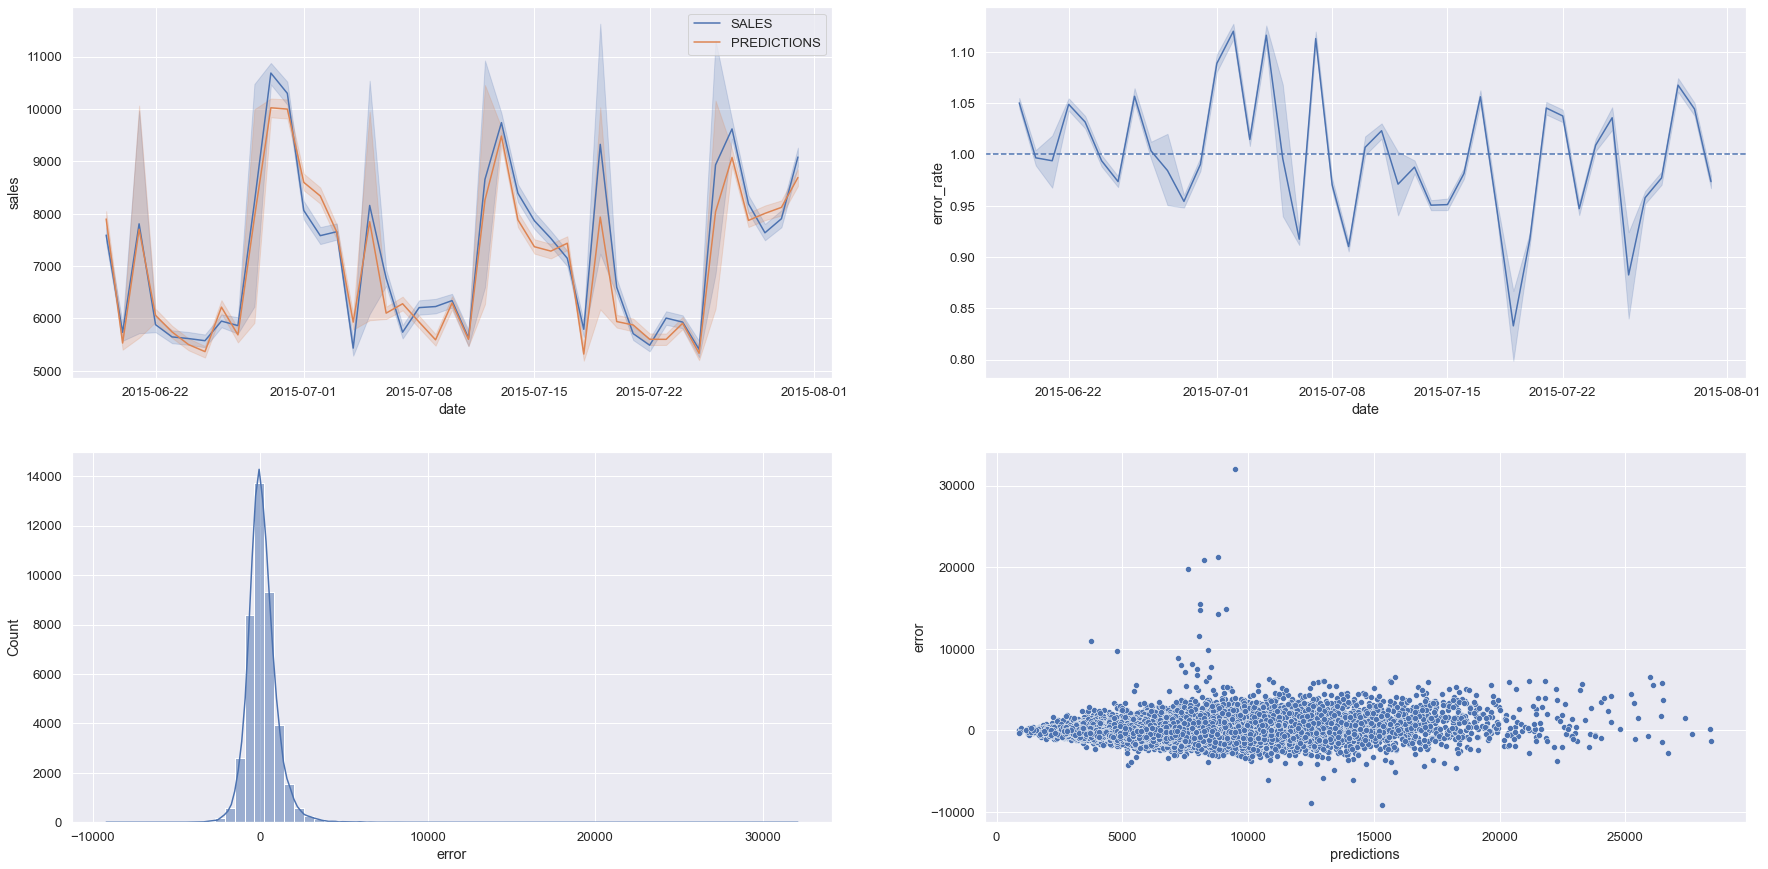

In [95]:
plt.figure(figsize=(30, 15))

plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot(2, 2, 3)
sns.histplot(x='error', data=df9, bins=70, kde=True)

plt.subplot(2, 2, 4 )
sns.scatterplot(x='predictions', y='error', data=df9);

## 10.0 MODEL DEPLOY 

## 10.1 Rossmann Class

In [ ]:
import pickle
import math
import datetime
import inflection

import pandas  as pd
import numpy   as np

class Rossmann (object):
    def __init__(self):
        self.home_path ='parameters/'
        self.rescaling_year                           = pickle.load(open(self.home_path + 'rescaling_year_c01.pkl', 'rb'))
        self.rescaling_competition_distance           = pickle.load(open(self.home_path + 'rescaling_competition_distance_c01.pkl', 'rb'))
        self.rescaling_competition_open_since_month   = pickle.load(open(self.home_path + 'rescaling_competition_open_since_month_c01.pkl', 'rb'))
        self.rescaling_competition_open_since_year    = pickle.load(open(self.home_path + 'rescaling_competition_open_since_year_c01.pkl', 'rb'))
        self.rescaling_competition_open_timein_months = pickle.load(open(self.home_path + 'rescaling_competition_open_timein_months_c01.pkl', 'rb'))
        self.rescaling_promo2_since_timein_weeks      = pickle.load(open(self.home_path + 'rescaling_promo2_since_timein_weeks_c01.pkl', 'rb'))
        self.rescaling_promo2_since_year              = pickle.load(open(self.home_path + 'rescaling_promo2_since_year_c01.pkl', 'rb'))                                                                                                               
        self.transforming_store_type                  = pickle.load(open(self.home_path + 'transforming_store_type_c01.pkl', 'rb'))   
                                                                 

    def data_cleaning(self, df1):
        
        ## 1.1 RENAME COLUMNS
        
        old_cols = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)
        new_cols  = list(map(snakecase, old_cols))

        # rename
        df1.columns = new_cols
        df1.rename(columns={'promo': 'is_promo', 'promo2': 'promo2_participant', 'promo_interval':'promo2_interval'},  inplace = True)
        
                                                                 
        ## 1.2 FILLOUT NA

        # competition distance
        max_dist = df1['competition_distance'].max()
        new_max_dist = max_dist * 1.5
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: new_max_dist if math.isnan(x) else x)                                                        
        
        df1['date'] = pd.to_datetime(df1['date'])

        # 'competition_open_since_month' and 'competition_open_since_year'
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else 
                                                                  x['competition_open_since_month'], axis=1)

        df1['competition_open_since_year']  = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else 
                                                                  x['competition_open_since_year'], axis=1)
                                                                
        # promo2_since_week and 'promo2_since_year'
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else 
                                                       x['promo2_since_week'], axis=1)

        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else 
                                                       x['promo2_since_year'], axis=1)
        
        # 'promo_interval' 
        # creating a dictionary to replace the number of the month (which I will extract from date) with the name
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        # replacing every NA in 'promo_inteval' with 0, because these are stores that did not participate in the promotion
        df1['promo2_interval'].fillna(0, inplace=True)

        # extracting the month from date with 'month_map'
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        # variable to tell if the purchase happened on a promotion
        df1['is_promo2'] = df1[['promo2_interval', 'month_map']].apply(lambda x: 0 if x['promo2_interval'] == 0 else 
                                                                                 1 if x['month_map'] in x['promo2_interval'].split(',') else 0, axis=1)
        
        ## 1.3 CHANGE VARIABLE TYPES
                                                                 
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
        df1['competition_open_since_year']  = df1['competition_open_since_year'].astype(np.int64)

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)  
      
        return df1
       
        
    def feature_engineering(self, df2):
        
        ## 2.1 FEATURE ENGINEERING    
                                                                 
        # year
        df2['year'] = df2['date'].dt.year.astype(np.int64)

        # month
        df2['month'] = df2['date'].dt.month.astype(np.int64)

        # day
        df2['day'] = df2['date'].dt.day.astype(np.int64)

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # creating 'competition_open_since' by combining 'competition_open_since_year' and 'competition_open_since_month'
        df2['competition_open_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                              month=x['competition_open_since_month'],day=1), axis=1)

        # creating 'competition_time_month' by calculating the difference between 'date' and 'competition_open_since'
        df2['competition_open_timein_months'] = ((pd.to_datetime(df2['date']).dt.date - pd.to_datetime(df2['competition_open_since']
                                                                                                      ).dt.date)/30
                                                ).apply(lambda x: x.days).astype(np.int64)

        # creating 'promo2_since' by 'combining promo2_since_year' and 'promo2_since_week'
        df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) 
        df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w'
                                                                                            ) - datetime.timedelta(days=7))  
        #the -1 and -%w pattern tells the parser to pick the monday in that week

        # creating 'promo2_since_timein_weeks' by calculating the difference between 'date' and 'promo2_since':
        df2['promo2_since_timein_weeks'] = ((pd.to_datetime(df2['date']).dt.date - pd.to_datetime(df2['promo2_since']).dt.date)/7
                                           ).apply(lambda x: x.days).astype(np.int64)

        # changing assortment attribute by given classification
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 
                                                              'extra' if x == 'b' else 
                                                              'extended')

        # changing 'state_holiday' attribute by given classification
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                                    'easter_holiday' if x == 'b' else 
                                                                    'christmas' if x == 'c' else 
                                                                    'regular_day')  
                                                                 
         ## 2.2 VARIABLE FILTERING
        
        df2 = df2[(df2['open']!= 0)]        
        cols_drop = ['open', 'promo2_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2
    
    def data_preparation(self, df5):
        
        ## 3.1 RESCALING
        
        df5['year']                           = self.rescaling_year.transform(df5[['year']].values)
        df5['competition_distance']           = self.rescaling_competition_distance.transform(df5[['competition_distance']].values)                                                        
        df5['competition_open_since_month']   = self.rescaling_competition_open_since_month.transform(df5[['competition_open_since_month']].values)
        df5['competition_open_since_year']    = self.rescaling_competition_open_since_year.transform(df5[['competition_open_since_year']].values)
        df5['competition_open_timein_months'] = self.rescaling_competition_open_timein_months.transform(df5[['competition_open_timein_months']].values)
        df5['promo2_since_timein_weeks']      = self.rescaling_promo2_since_timein_weeks.transform(df5[['promo2_since_timein_weeks']].values)
        df5['promo2_since_year']              = self.rescaling_promo2_since_year.transform(df5[['promo2_since_year']].values)

        ## 3.2 ENCONDING
        
        # state_holiday - one hot enconding (each holiday becomes a column)
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - label enconding (each type becomes a value in a range)
        df5['store_type'] = self.transforming_store_type.transform(df5[['store_type']])

        # assortment - ordinal enconding (each assortment becomes a value in a hierarchy)
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)       
        
                                                                 
        ## 3.3 NATURE TRANSFORMATION

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))
        
        cols_selected = ['store', 'is_promo', 'is_promo2', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                         'competition_open_since_year', 'promo2_participant', 'promo2_since_week', 'promo2_since_year', 'competition_open_timein_months',
                         'promo2_since_timein_weeks', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'year'] 
        
        return df5[cols_selected]

                                                                         
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)

        # joining prediction into the original data
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [ ]:
import os
import pickle
import pandas as pd

from flask              import Flask, request, Response
from rossmann.Rossmann  import Rossmann 

# loading model
model = pickle.load(open('model/model_xgb_tuned_c01.pkl', 'rb'))

# initializing API
app = Flask(__name__)

@app.route('/rossmann/prediction', methods=['POST']) 
def rossmann_prediction():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance(test_json, dict): # if unique example
            test_df = pd.DataFrame(test_json, index=[0])
            print('1')
        else: # if multiple examples
            test_df = pd.DataFrame(test_json, columns=test_json[0].keys())
            print('2')

        # instantiate Rossmann Class
        pipeline = Rossmann()
        print('3')

        # data cleaning
        df1 = pipeline.data_cleaning(test_df)
        print('4')

        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        print('5')

        # data preparation
        df3 = pipeline.data_preparation(df2)
        print('6')

        # prediction
        df_response = pipeline.get_prediction(model, test_df, df3)
        print('7')

        return df_response

    else: # if empty
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run('192.168.1.107', port=port)

## 10.3 API Tester

In [139]:
import json 

# loading test dataset
df10 = pd.read_csv('C:/Users/anacl/Documents/repos/drugstore_sales_prediction/data/raw/test.csv', low_memory=False)

# merging df_test and df_store_raw (available at the beginning of the notbook)
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choosing one store for prediction
df_test = df_test[df_test['Store'].isin([20, 15])]

# deleting closed days
df_test = df_test[df_test['Open']!= 0]
df_test = df_test[~df_test.isnull()]

df_test = df_test.drop('Id', axis=1)

# converting df to json
data = json.dumps(df_test.to_dict(orient='records'))

In [143]:
# API request

# cloud test
url = 'https://sales-predictions-for-rossmann.herokuapp.com/rossmann/prediction'

header = {'Content-type': 'application/json'}
data = json.dumps(df_test.to_dict(orient='records'))

r = requests.post(url, data = data, headers = header)
print(f'Status Code {r.status_code}')

Status Code 200


In [144]:
# transform dataframe in json
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())
d1.head() # prediction on the last column

,store,day_of_week,date,open,is_promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_open_since,competition_open_timein_months,promo2_since,promo2_since_timein_weeks,prediction
0,15,4,2015-09-17T00:00:00.000Z,1.00,1,regular_day,0,d,extended,4110.00,...,2015,9,17,38,2015-37,2010-03-01T00:00:00.000Z,67,2011-03-28T00:00:00.000Z,233,6653.73
1,20,4,2015-09-17T00:00:00.000Z,1.00,1,regular_day,0,d,basic,2340.00,...,2015,9,17,38,2015-37,2009-05-01T00:00:00.000Z,77,2014-09-29T00:00:00.000Z,50,8170.48
2,15,3,2015-09-16T00:00:00.000Z,1.00,1,regular_day,0,d,extended,4110.00,...,2015,9,16,38,2015-37,2010-03-01T00:00:00.000Z,67,2011-03-28T00:00:00.000Z,233,6659.14
3,20,3,2015-09-16T00:00:00.000Z,1.00,1,regular_day,0,d,basic,2340.00,...,2015,9,16,38,2015-37,2009-05-01T00:00:00.000Z,77,2014-09-29T00:00:00.000Z,50,8005.60
4,15,2,2015-09-15T00:00:00.000Z,1.00,1,regular_day,0,d,extended,4110.00,...,2015,9,15,38,2015-37,2010-03-01T00:00:00.000Z,67,2011-03-28T00:00:00.000Z,233,7658.56


In [145]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()
d2

,store,prediction
0,15,276263.36
1,20,303988.33


In [146]:
for i in range(len(d2)):
    print(f"The store id {d2.loc[i,'store']} will sell US$ {d2.loc[i,'prediction']:,.2f} in the next 6 weeks")

The store 15 will sell US$ 276,263.36 in the next 6 weeks
The store 20 will sell US$ 303,988.33 in the next 6 weeks
